# Optimizer in Deep Learning

## Import Libraries

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import models, transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 18.7 MB/s eta 0:00:00


## device agnostic code

In [ ]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load pre train model on imagenet

In [ ]:
model_18 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
model_best_transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

model_18, model_best_transform

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [ ]:
feature_number = model_18.fc.in_features
model_18.fc = nn.Linear(feature_number, 10).to(device)

## Load Dataset

In [ ]:
train_data = datasets.STL10(root = 'data', split = "train", transform = model_best_transform, download = True)
test_data = datasets.STL10(root = 'data', split = "test", transform = model_best_transform, download = True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting data/stl10_binary.tar.gz to data
Files already downloaded and verified


In [ ]:
print(len(train_data)), print(len(test_data))

5000
8000


(None, None)

## Make dataloader

In [ ]:
# setup batchsize hyperparameter
BATCH_SIZE = 32

# turn dataset into batches
train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

print(f"DataLoader: {train_dataloader}, {test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f3e15f39a90>, <torch.utils.data.dataloader.DataLoader object at 0x7f3e15f47d30>
Length of train dataloader: 156 batches of 32
Length of test dataloader: 250 batches of 32


## visulize data

In [ ]:
class_names = train_data.classes
class_names

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

Image: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'bird')

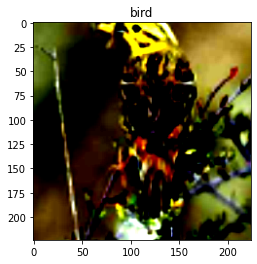

In [ ]:
image, label = train_data[0]
print(f"Image: {image.shape}")
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
# image

## Train and Test Loop

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0
  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    model.train()

    # 1. Forward step
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # print(torch.argmax(pred, dim=1))
    
    # print(y_train)

    # print(torch.argmax(pred, dim=0))
    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Plot graph of Loss and Accuray

In [ ]:
def plot_graph(train_losses, test_losses, train_accs, test_accs):
  plt.figure(figsize = (20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot(range(len(train_accs)), train_accs, label = "Train Accuracy")
  plt.plot(range(len(test_accs)), test_accs, label = "Test Accuracy")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.show()

## Loss and Accuracy function

In [ ]:
loss_fn = nn.CrossEntropyLoss()

accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)

# Train Model on RMSProp


current exp | total: 1 | 16
Training with --- lr rate: 0.1, alpha: 0.85, momentum: 0.88, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.7906 | Test Loss: 1.0975 | Train Accuray: 0.5566 | Test Accuracy: 0.6725
Epoch: 2  Train Loss: 0.4922 | Test Loss: 0.4953 | Train Accuray: 0.8291 | Test Accuracy: 0.8158
Epoch: 3  Train Loss: 0.2885 | Test Loss: 0.4186 | Train Accuray: 0.8796 | Test Accuracy: 0.8402
Epoch: 4  Train Loss: 0.1433 | Test Loss: 0.4398 | Train Accuray: 0.9162 | Test Accuracy: 0.8413
Epoch: 5  Train Loss: 0.0884 | Test Loss: 3.4110 | Train Accuray: 0.9363 | Test Accuracy: 0.6776


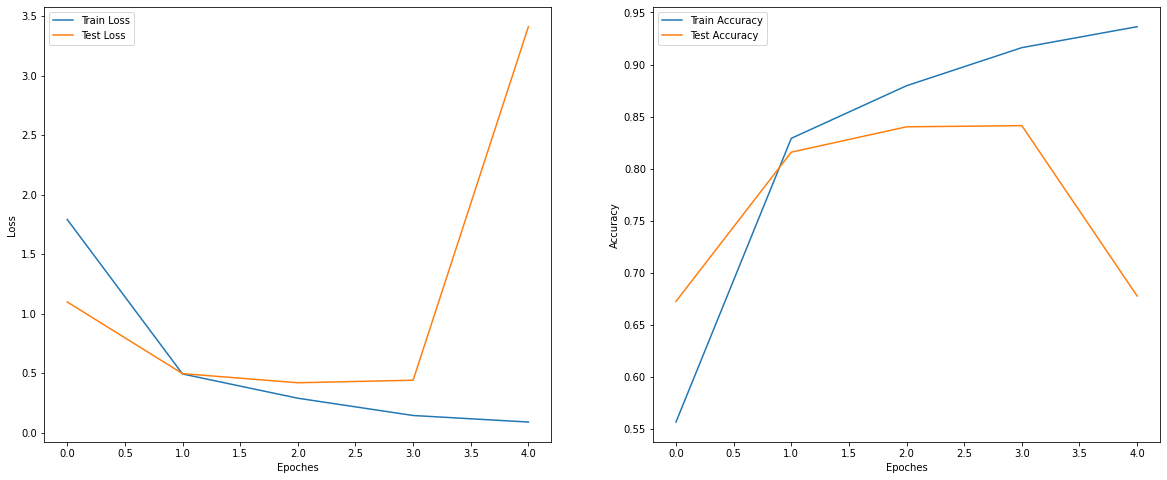


current exp | total: 2 | 16
Training with --- lr rate: 0.1, alpha: 0.85, momentum: 0.88, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.9924 | Test Loss: 0.6528 | Train Accuray: 0.4488 | Test Accuracy: 0.7585
Epoch: 2  Train Loss: 0.5919 | Test Loss: 1.0538 | Train Accuray: 0.7974 | Test Accuracy: 0.7131
Epoch: 3  Train Loss: 0.3266 | Test Loss: 0.4948 | Train Accuray: 0.8657 | Test Accuracy: 0.8200
Epoch: 4  Train Loss: 0.1720 | Test Loss: 0.6708 | Train Accuray: 0.9093 | Test Accuracy: 0.8041
Epoch: 5  Train Loss: 0.1330 | Test Loss: 0.4917 | Train Accuray: 0.9230 | Test Accuracy: 0.8319


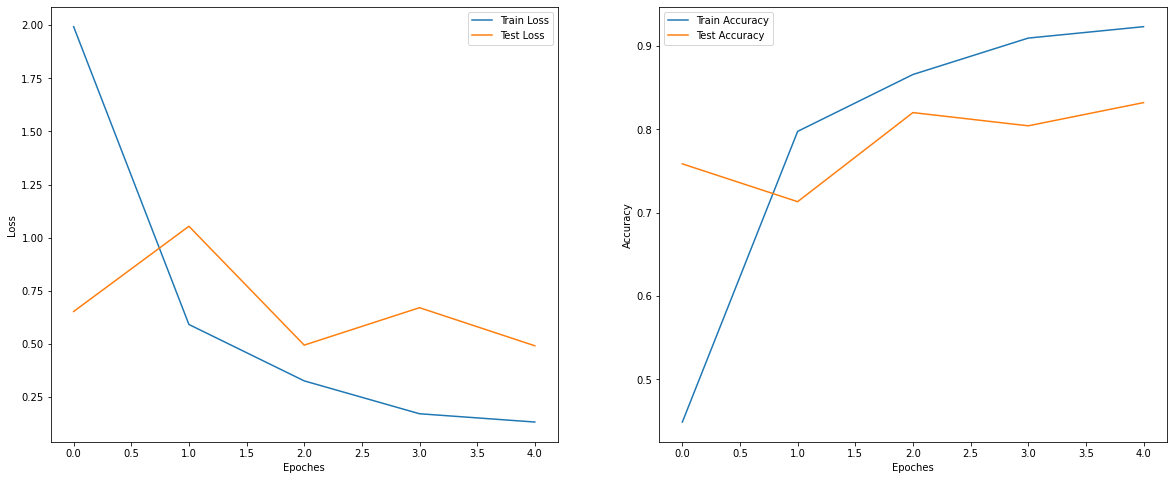


current exp | total: 3 | 16
Training with --- lr rate: 0.1, alpha: 0.85, momentum: 0.99, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.1350 | Test Loss: 0.9930 | Train Accuray: 0.6885 | Test Accuracy: 0.6931
Epoch: 2  Train Loss: 0.3412 | Test Loss: 0.6725 | Train Accuray: 0.8648 | Test Accuracy: 0.7846
Epoch: 3  Train Loss: 0.1610 | Test Loss: 0.4775 | Train Accuray: 0.9143 | Test Accuracy: 0.8297
Epoch: 4  Train Loss: 0.0973 | Test Loss: 0.4442 | Train Accuray: 0.9335 | Test Accuracy: 0.8483
Epoch: 5  Train Loss: 0.0546 | Test Loss: 0.6146 | Train Accuray: 0.9474 | Test Accuracy: 0.8313


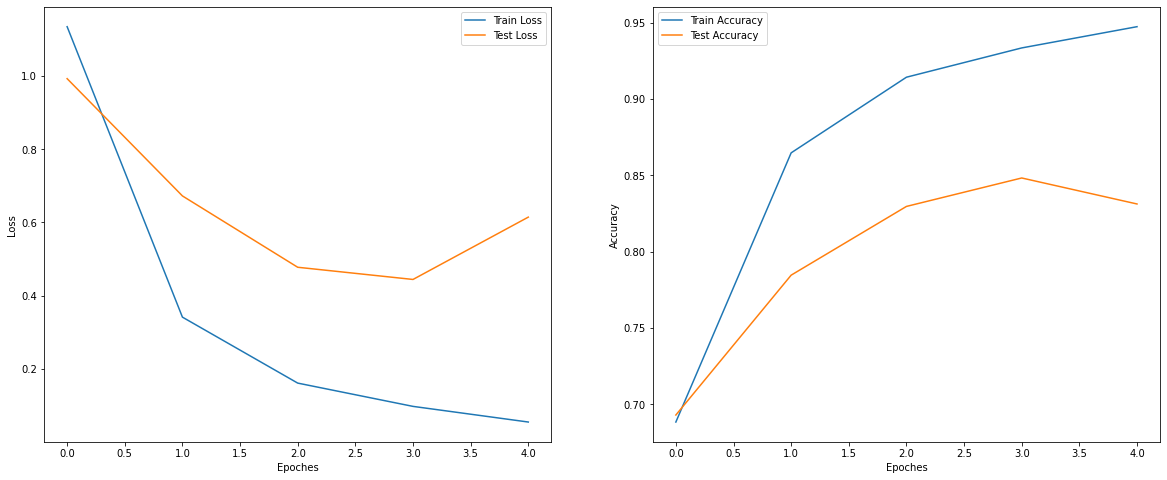


current exp | total: 4 | 16
Training with --- lr rate: 0.1, alpha: 0.85, momentum: 0.99, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.0820 | Test Loss: 1.2154 | Train Accuray: 0.7011 | Test Accuracy: 0.7108
Epoch: 2  Train Loss: 0.3772 | Test Loss: 0.7847 | Train Accuray: 0.8530 | Test Accuracy: 0.7840
Epoch: 3  Train Loss: 0.1718 | Test Loss: 0.4356 | Train Accuray: 0.9123 | Test Accuracy: 0.8408
Epoch: 4  Train Loss: 0.0886 | Test Loss: 0.4263 | Train Accuray: 0.9392 | Test Accuracy: 0.8467
Epoch: 5  Train Loss: 0.0449 | Test Loss: 0.4282 | Train Accuray: 0.9505 | Test Accuracy: 0.8627


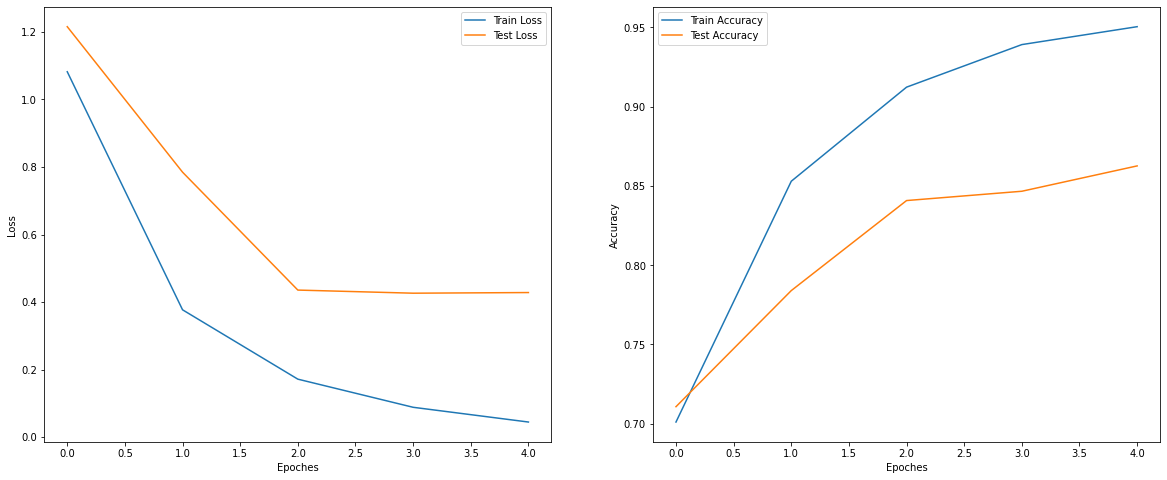


current exp | total: 5 | 16
Training with --- lr rate: 0.1, alpha: 0.95, momentum: 0.88, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.9176 | Test Loss: 2.2220 | Train Accuray: 0.1058 | Test Accuracy: 0.2334
Epoch: 2  Train Loss: 1.8841 | Test Loss: 2.2178 | Train Accuray: 0.2111 | Test Accuracy: 0.1871
Epoch: 3  Train Loss: 1.6332 | Test Loss: 1.4459 | Train Accuray: 0.3188 | Test Accuracy: 0.4371
Epoch: 4  Train Loss: 1.4355 | Test Loss: 1.8116 | Train Accuray: 0.4463 | Test Accuracy: 0.3775
Epoch: 5  Train Loss: 1.2005 | Test Loss: 1.2521 | Train Accuray: 0.5614 | Test Accuracy: 0.5170


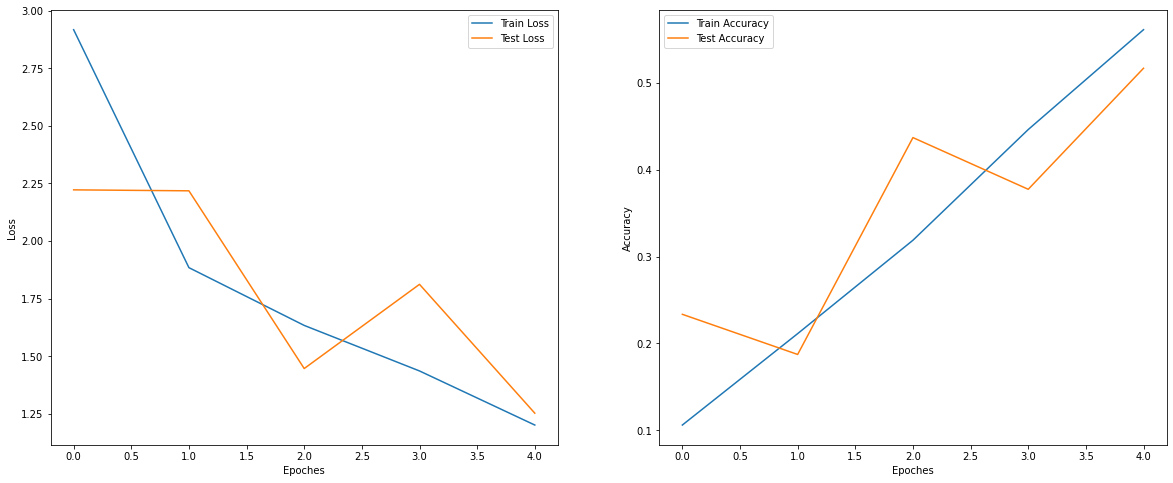


current exp | total: 6 | 16
Training with --- lr rate: 0.1, alpha: 0.95, momentum: 0.88, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.7997 | Test Loss: 1.7391 | Train Accuray: 0.1502 | Test Accuracy: 0.2894
Epoch: 2  Train Loss: 1.5685 | Test Loss: 1.7242 | Train Accuray: 0.3993 | Test Accuracy: 0.4416
Epoch: 3  Train Loss: 1.0108 | Test Loss: 0.7903 | Train Accuray: 0.6416 | Test Accuracy: 0.7063
Epoch: 4  Train Loss: 0.5734 | Test Loss: 1.0268 | Train Accuray: 0.7847 | Test Accuracy: 0.6814
Epoch: 5  Train Loss: 0.3522 | Test Loss: 1.8904 | Train Accuray: 0.8547 | Test Accuracy: 0.5824


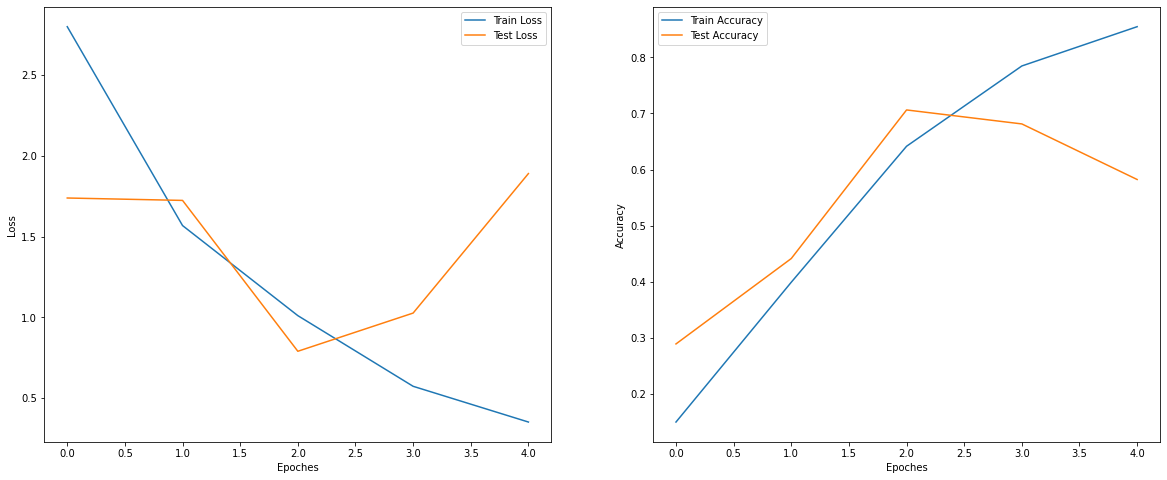


current exp | total: 7 | 16
Training with --- lr rate: 0.1, alpha: 0.95, momentum: 0.99, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.2413 | Test Loss: 0.6339 | Train Accuray: 0.6796 | Test Accuracy: 0.7650
Epoch: 2  Train Loss: 0.3498 | Test Loss: 0.4497 | Train Accuray: 0.8646 | Test Accuracy: 0.8342
Epoch: 3  Train Loss: 0.1958 | Test Loss: 0.4141 | Train Accuray: 0.9021 | Test Accuracy: 0.8356
Epoch: 4  Train Loss: 0.1134 | Test Loss: 0.2978 | Train Accuray: 0.9297 | Test Accuracy: 0.8756
Epoch: 5  Train Loss: 0.0451 | Test Loss: 0.5316 | Train Accuray: 0.9523 | Test Accuracy: 0.8388


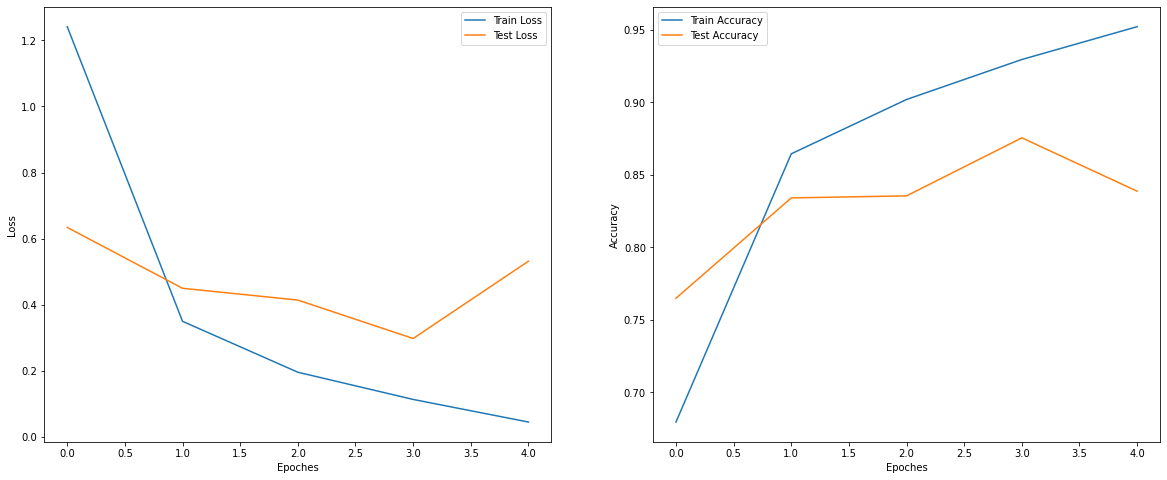


current exp | total: 8 | 16
Training with --- lr rate: 0.1, alpha: 0.95, momentum: 0.99, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.1240 | Test Loss: 0.8949 | Train Accuray: 0.6988 | Test Accuracy: 0.6964
Epoch: 2  Train Loss: 0.3586 | Test Loss: 0.7462 | Train Accuray: 0.8666 | Test Accuracy: 0.7687
Epoch: 3  Train Loss: 0.2104 | Test Loss: 0.4896 | Train Accuray: 0.8947 | Test Accuracy: 0.8243
Epoch: 4  Train Loss: 0.1049 | Test Loss: 0.5677 | Train Accuray: 0.9305 | Test Accuracy: 0.8130
Epoch: 5  Train Loss: 0.0768 | Test Loss: 1.6543 | Train Accuray: 0.9381 | Test Accuracy: 0.7651


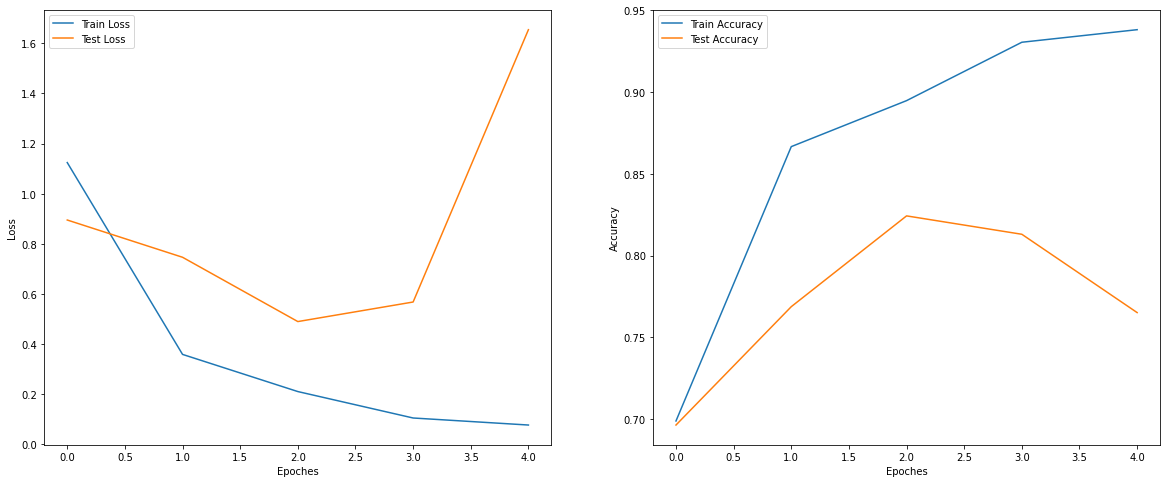


current exp | total: 9 | 16
Training with --- lr rate: 0.01, alpha: 0.85, momentum: 0.88, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6108 | Test Loss: 0.2175 | Train Accuray: 0.8201 | Test Accuracy: 0.9119
Epoch: 2  Train Loss: 0.1789 | Test Loss: 0.1807 | Train Accuray: 0.9272 | Test Accuracy: 0.9131
Epoch: 3  Train Loss: 0.1007 | Test Loss: 0.1510 | Train Accuray: 0.9429 | Test Accuracy: 0.9197
Epoch: 4  Train Loss: 0.0580 | Test Loss: 0.1443 | Train Accuray: 0.9592 | Test Accuracy: 0.9188
Epoch: 5  Train Loss: 0.0379 | Test Loss: 0.1410 | Train Accuray: 0.9578 | Test Accuracy: 0.9228


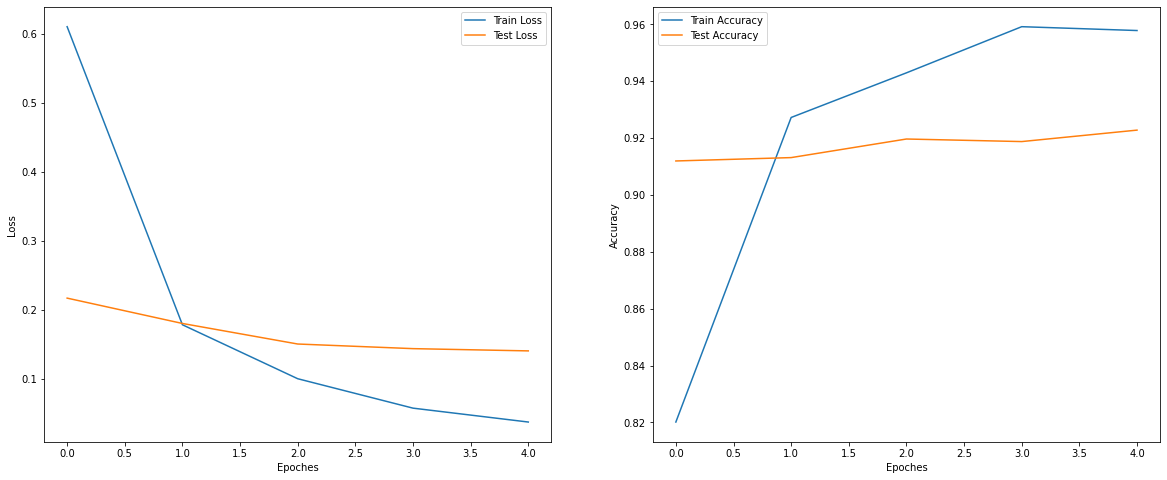


current exp | total: 10 | 16
Training with --- lr rate: 0.01, alpha: 0.85, momentum: 0.88, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6103 | Test Loss: 0.2399 | Train Accuray: 0.8176 | Test Accuracy: 0.9056
Epoch: 2  Train Loss: 0.1789 | Test Loss: 0.1830 | Train Accuray: 0.9280 | Test Accuracy: 0.9102
Epoch: 3  Train Loss: 0.1025 | Test Loss: 0.1471 | Train Accuray: 0.9410 | Test Accuracy: 0.9192
Epoch: 4  Train Loss: 0.0582 | Test Loss: 0.1478 | Train Accuray: 0.9578 | Test Accuracy: 0.9165
Epoch: 5  Train Loss: 0.0386 | Test Loss: 0.1381 | Train Accuray: 0.9578 | Test Accuracy: 0.9217


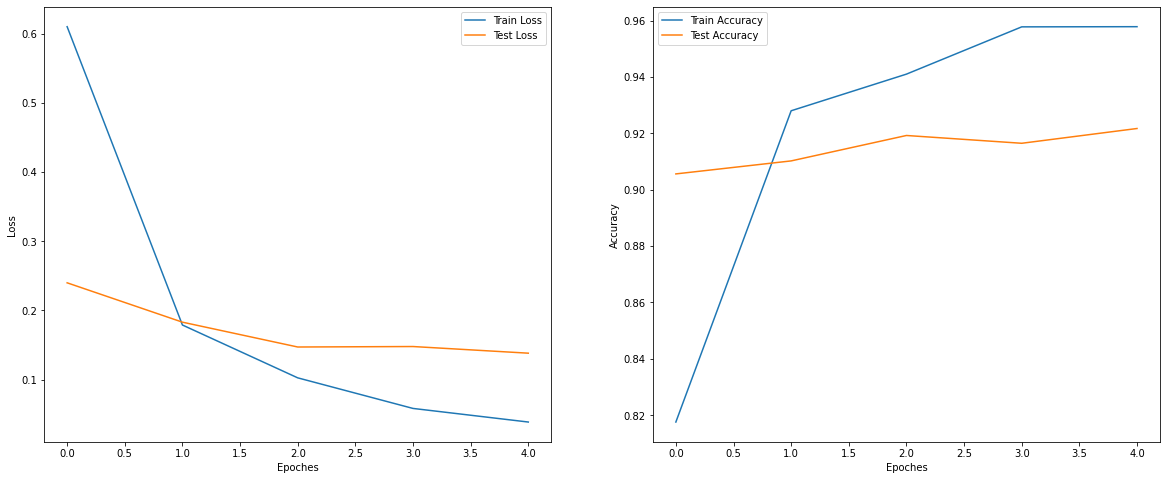


current exp | total: 11 | 16
Training with --- lr rate: 0.01, alpha: 0.85, momentum: 0.99, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6455 | Test Loss: 0.2428 | Train Accuray: 0.8119 | Test Accuracy: 0.9084
Epoch: 2  Train Loss: 0.1935 | Test Loss: 0.1765 | Train Accuray: 0.9262 | Test Accuracy: 0.9162
Epoch: 3  Train Loss: 0.1137 | Test Loss: 0.1533 | Train Accuray: 0.9402 | Test Accuracy: 0.9185
Epoch: 4  Train Loss: 0.0677 | Test Loss: 0.1446 | Train Accuray: 0.9561 | Test Accuracy: 0.9210
Epoch: 5  Train Loss: 0.0449 | Test Loss: 0.1388 | Train Accuray: 0.9567 | Test Accuracy: 0.9200


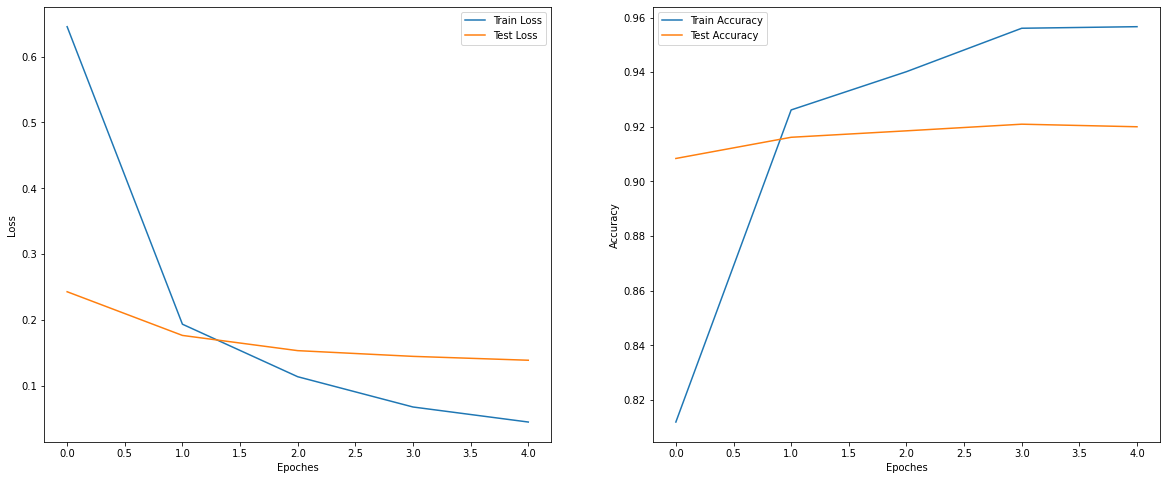


current exp | total: 12 | 16
Training with --- lr rate: 0.01, alpha: 0.85, momentum: 0.99, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6460 | Test Loss: 0.2386 | Train Accuray: 0.8140 | Test Accuracy: 0.9090
Epoch: 2  Train Loss: 0.1931 | Test Loss: 0.1785 | Train Accuray: 0.9254 | Test Accuracy: 0.9154
Epoch: 3  Train Loss: 0.1133 | Test Loss: 0.1533 | Train Accuray: 0.9401 | Test Accuracy: 0.9202
Epoch: 4  Train Loss: 0.0681 | Test Loss: 0.1486 | Train Accuray: 0.9561 | Test Accuracy: 0.9175
Epoch: 5  Train Loss: 0.0446 | Test Loss: 0.1360 | Train Accuray: 0.9570 | Test Accuracy: 0.9237


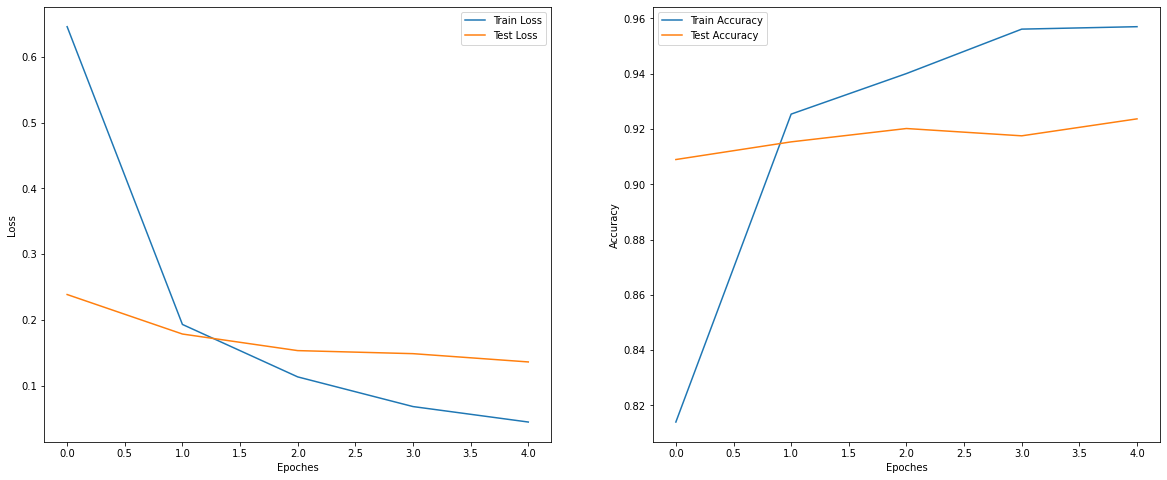


current exp | total: 13 | 16
Training with --- lr rate: 0.01, alpha: 0.95, momentum: 0.88, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6061 | Test Loss: 0.2259 | Train Accuray: 0.8206 | Test Accuracy: 0.9107
Epoch: 2  Train Loss: 0.1779 | Test Loss: 0.1737 | Train Accuray: 0.9270 | Test Accuracy: 0.9131
Epoch: 3  Train Loss: 0.1001 | Test Loss: 0.1525 | Train Accuray: 0.9428 | Test Accuracy: 0.9179
Epoch: 4  Train Loss: 0.0582 | Test Loss: 0.1456 | Train Accuray: 0.9589 | Test Accuracy: 0.9190
Epoch: 5  Train Loss: 0.0377 | Test Loss: 0.1418 | Train Accuray: 0.9580 | Test Accuracy: 0.9206


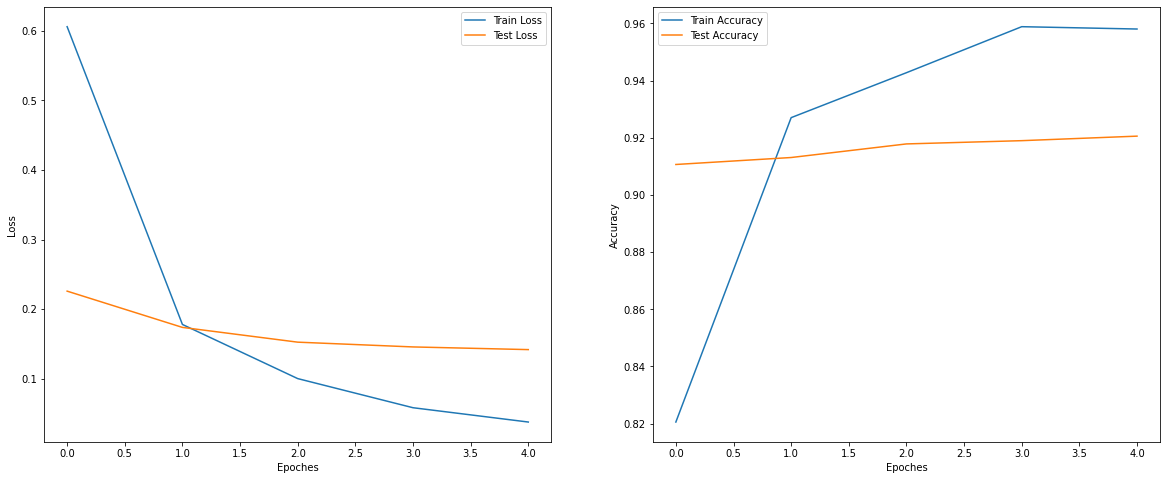


current exp | total: 14 | 16
Training with --- lr rate: 0.01, alpha: 0.95, momentum: 0.88, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6072 | Test Loss: 0.2214 | Train Accuray: 0.8235 | Test Accuracy: 0.9136
Epoch: 2  Train Loss: 0.1790 | Test Loss: 0.1683 | Train Accuray: 0.9268 | Test Accuracy: 0.9156
Epoch: 3  Train Loss: 0.1001 | Test Loss: 0.1505 | Train Accuray: 0.9421 | Test Accuracy: 0.9196
Epoch: 4  Train Loss: 0.0581 | Test Loss: 0.1445 | Train Accuray: 0.9594 | Test Accuracy: 0.9191
Epoch: 5  Train Loss: 0.0375 | Test Loss: 0.1371 | Train Accuray: 0.9576 | Test Accuracy: 0.9218


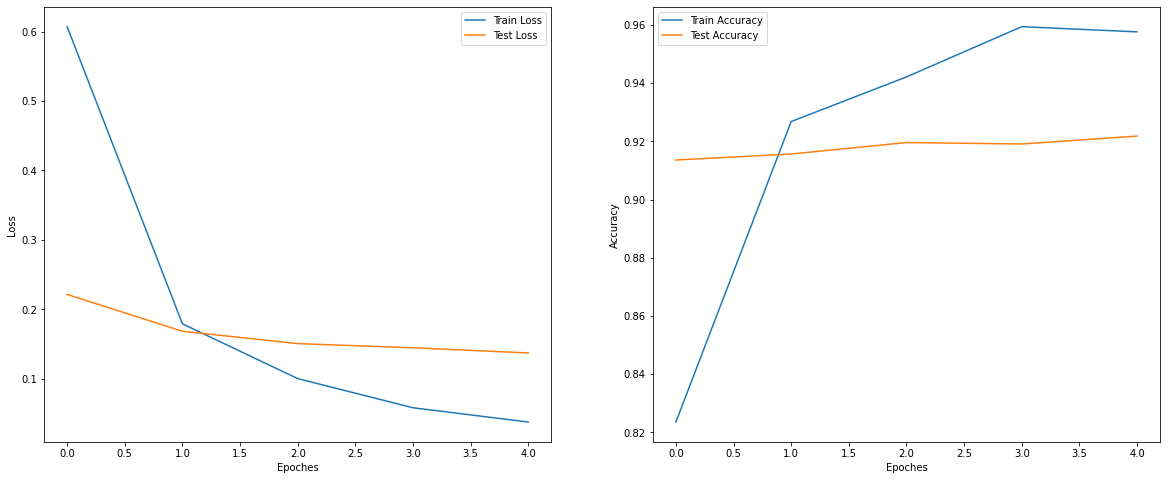


current exp | total: 15 | 16
Training with --- lr rate: 0.01, alpha: 0.95, momentum: 0.99, eps: 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6422 | Test Loss: 0.2471 | Train Accuray: 0.8144 | Test Accuracy: 0.9069
Epoch: 2  Train Loss: 0.1925 | Test Loss: 0.1736 | Train Accuray: 0.9260 | Test Accuracy: 0.9158
Epoch: 3  Train Loss: 0.1114 | Test Loss: 0.1558 | Train Accuray: 0.9407 | Test Accuracy: 0.9167
Epoch: 4  Train Loss: 0.0681 | Test Loss: 0.1517 | Train Accuray: 0.9572 | Test Accuracy: 0.9173
Epoch: 5  Train Loss: 0.0447 | Test Loss: 0.1434 | Train Accuray: 0.9568 | Test Accuracy: 0.9195


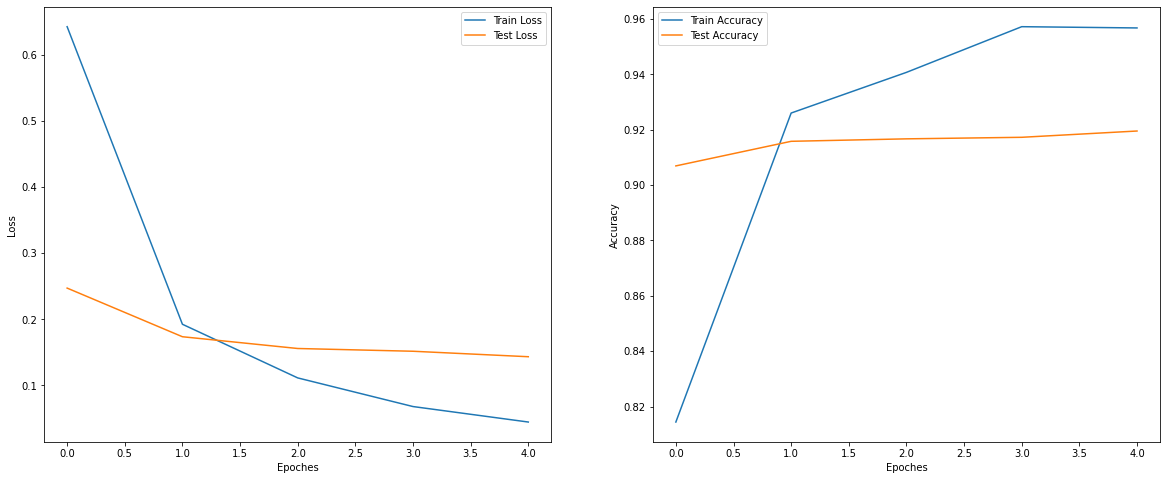


current exp | total: 16 | 16
Training with --- lr rate: 0.01, alpha: 0.95, momentum: 0.99, eps: 1e-07


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.6429 | Test Loss: 0.2375 | Train Accuray: 0.8112 | Test Accuracy: 0.9080
Epoch: 2  Train Loss: 0.1914 | Test Loss: 0.1835 | Train Accuray: 0.9262 | Test Accuracy: 0.9142
Epoch: 3  Train Loss: 0.1111 | Test Loss: 0.1542 | Train Accuray: 0.9420 | Test Accuracy: 0.9191
Epoch: 4  Train Loss: 0.0669 | Test Loss: 0.1455 | Train Accuray: 0.9569 | Test Accuracy: 0.9186
Epoch: 5  Train Loss: 0.0443 | Test Loss: 0.1344 | Train Accuray: 0.9566 | Test Accuracy: 0.9222


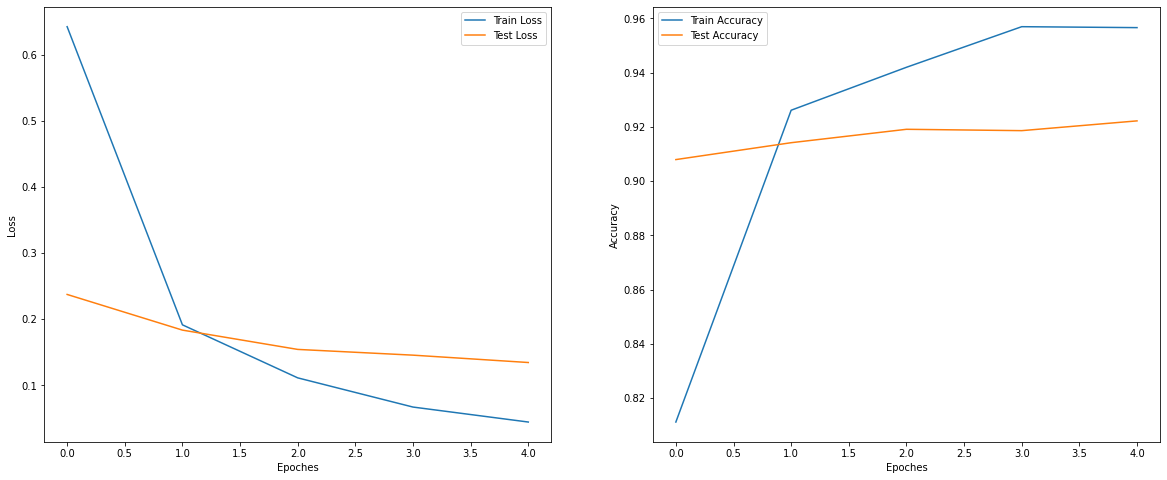

In [ ]:
# Hyperparms
lr_rate = [0.1,0.01] # learning rate
alpha = [0.85,0.95] # smoothing constant
momentum = [0.88,0.99] # momentum factor
eps = [1e-5,1e-7] # term added to the denominator to improve numerical stability

hyper_params = [(lr,a,m,e) for lr in lr_rate for a in alpha for m in momentum for e in eps]
# print(parms_combs)

cur_iter,total_iter = 1, len(lr_rate)*len(alpha)*len(momentum)*len(eps)

# init. epochs
epoches = 5

for h_p in hyper_params:
  print()
  print(f"current exp | total: {cur_iter} | {total_iter}")
  print(f"Training with --- lr rate: {h_p[0]}, alpha: {h_p[1]}, momentum: {h_p[2]}, eps: {h_p[3]}")
  model_18 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1).to(device)
  feature_number = model_18.fc.in_features
  model_18.fc = nn.Linear(feature_number, len(class_names)).to(device)

  optimizer = torch.optim.RMSprop(model_18.parameters(), h_p[0], h_p[1], h_p[2], h_p[3])
  model18_train_loss, model18_test_loss = [], []
  model18_train_accs, model18_test_accs = [], []

  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  for epoch in tqdm(range(epoches)):

    train_loss, train_acc = train_loop(model = model_18, dataloader = train_dataloader,
                                      loss_fn = loss_fn, optimizer = optimizer,
                                      accuracy_fn = accuracy_fn, device = device)
    
    test_loss, test_acc = test_loop(model = model_18, dataloader = test_dataloader,
                                    loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                    device = device)
    
    model18_train_loss.append(train_loss.item())
    model18_test_loss.append(test_loss.item())
    model18_train_accs.append(train_acc.item())
    model18_test_accs.append(test_acc.item())

    print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
  cur_iter += 1
  plot_graph(model18_train_loss, model18_test_loss, model18_train_accs, model18_test_accs)


# Train Model on Adam


current exp | total: 1 | 16
Training with --- lr rate: 0.001, betas: (0.85, 0.8585), eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.9884 | Test Loss: 1.5154 | Train Accuray: 0.6597 | Test Accuracy: 0.5054
Epoch: 2  Train Loss: 0.7906 | Test Loss: 1.1153 | Train Accuray: 0.7329 | Test Accuracy: 0.6002
Epoch: 3  Train Loss: 0.6700 | Test Loss: 0.8961 | Train Accuray: 0.7609 | Test Accuracy: 0.6738
Epoch: 4  Train Loss: 0.5932 | Test Loss: 1.7310 | Train Accuray: 0.7891 | Test Accuracy: 0.5446
Epoch: 5  Train Loss: 0.5291 | Test Loss: 1.0150 | Train Accuray: 0.7996 | Test Accuracy: 0.6789


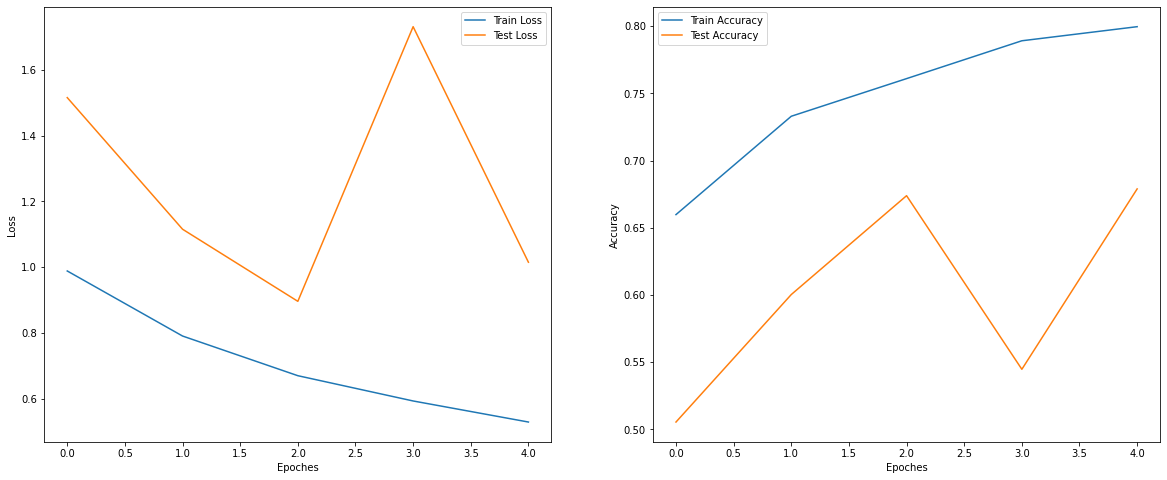


current exp | total: 2 | 16
Training with --- lr rate: 0.001, betas: (0.85, 0.8585), eps: 1e-05, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.9931 | Test Loss: 1.8059 | Train Accuray: 0.6632 | Test Accuracy: 0.5209
Epoch: 2  Train Loss: 0.7223 | Test Loss: 0.9595 | Train Accuray: 0.7498 | Test Accuracy: 0.6702
Epoch: 3  Train Loss: 0.5887 | Test Loss: 0.9306 | Train Accuray: 0.7831 | Test Accuracy: 0.6578
Epoch: 4  Train Loss: 0.5091 | Test Loss: 1.0205 | Train Accuray: 0.8172 | Test Accuracy: 0.6756
Epoch: 5  Train Loss: 0.4426 | Test Loss: 0.8368 | Train Accuray: 0.8283 | Test Accuracy: 0.7169


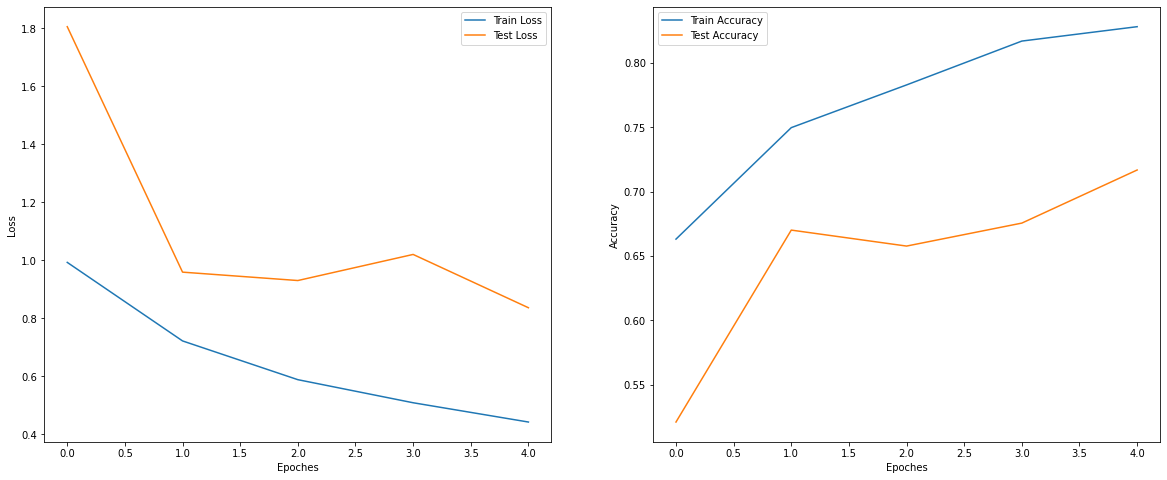


current exp | total: 3 | 16
Training with --- lr rate: 0.001, betas: (0.85, 0.8585), eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.0258 | Test Loss: 1.3763 | Train Accuray: 0.6586 | Test Accuracy: 0.5710
Epoch: 2  Train Loss: 0.8016 | Test Loss: 1.2520 | Train Accuray: 0.7232 | Test Accuracy: 0.5968
Epoch: 3  Train Loss: 0.6875 | Test Loss: 1.5829 | Train Accuray: 0.7631 | Test Accuracy: 0.5821
Epoch: 4  Train Loss: 0.6135 | Test Loss: 0.8783 | Train Accuray: 0.7809 | Test Accuracy: 0.6873
Epoch: 5  Train Loss: 0.5178 | Test Loss: 0.9943 | Train Accuray: 0.8117 | Test Accuracy: 0.7040


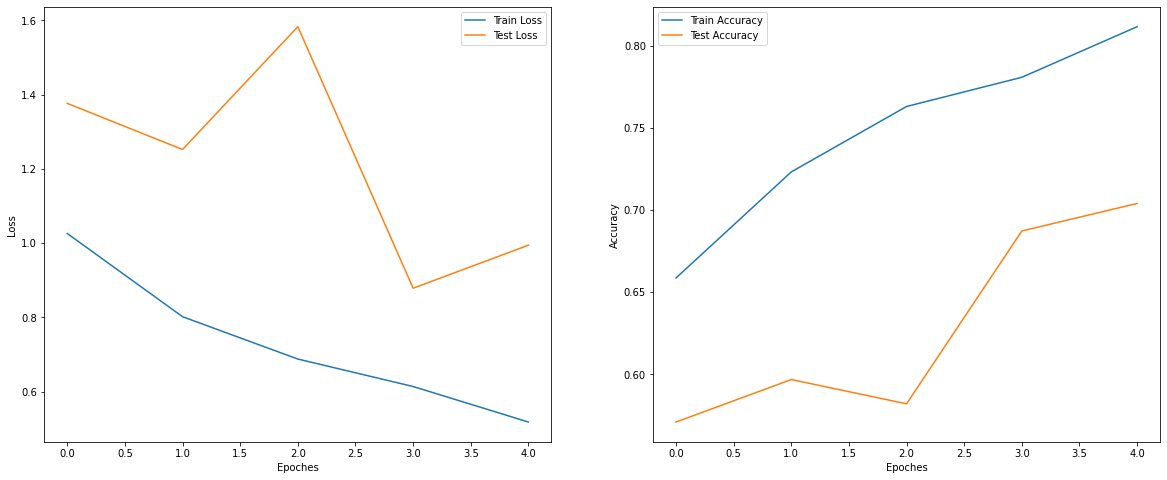


current exp | total: 4 | 16
Training with --- lr rate: 0.001, betas: (0.85, 0.8585), eps: 1e-07, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.9891 | Test Loss: 1.1424 | Train Accuray: 0.6616 | Test Accuracy: 0.6005
Epoch: 2  Train Loss: 0.7340 | Test Loss: 1.3643 | Train Accuray: 0.7395 | Test Accuracy: 0.5853
Epoch: 3  Train Loss: 0.5926 | Test Loss: 0.7604 | Train Accuray: 0.7890 | Test Accuracy: 0.7303
Epoch: 4  Train Loss: 0.5063 | Test Loss: 0.7417 | Train Accuray: 0.8069 | Test Accuracy: 0.7298
Epoch: 5  Train Loss: 0.4349 | Test Loss: 1.1705 | Train Accuray: 0.8370 | Test Accuracy: 0.6616


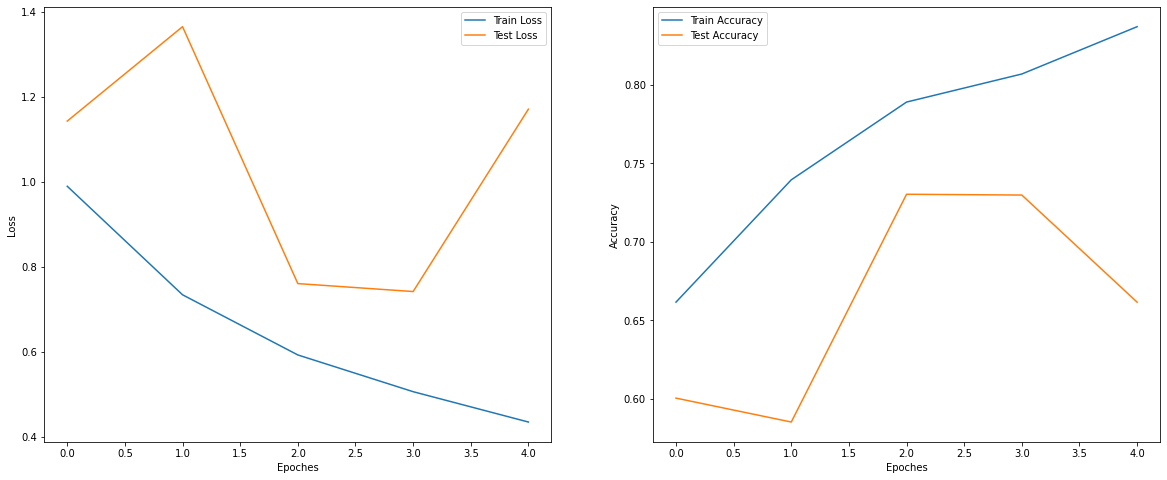


current exp | total: 5 | 16
Training with --- lr rate: 0.001, betas: (0.95, 0.9595), eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.9982 | Test Loss: 1.8071 | Train Accuray: 0.6579 | Test Accuracy: 0.5173
Epoch: 2  Train Loss: 0.8133 | Test Loss: 0.9059 | Train Accuray: 0.7180 | Test Accuracy: 0.6812
Epoch: 3  Train Loss: 0.6829 | Test Loss: 1.1911 | Train Accuray: 0.7594 | Test Accuracy: 0.6124
Epoch: 4  Train Loss: 0.6171 | Test Loss: 1.0617 | Train Accuray: 0.7794 | Test Accuracy: 0.6765
Epoch: 5  Train Loss: 0.5162 | Test Loss: 0.8960 | Train Accuray: 0.8126 | Test Accuracy: 0.7098


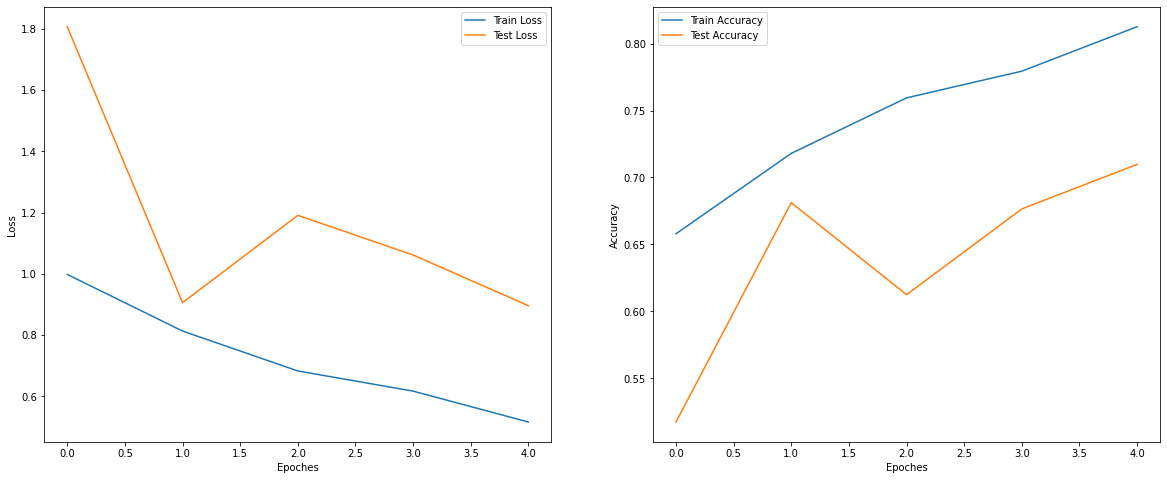


current exp | total: 6 | 16
Training with --- lr rate: 0.001, betas: (0.95, 0.9595), eps: 1e-05, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.9819 | Test Loss: 1.3389 | Train Accuray: 0.6525 | Test Accuracy: 0.5785
Epoch: 2  Train Loss: 0.7563 | Test Loss: 0.9456 | Train Accuray: 0.7320 | Test Accuracy: 0.6817
Epoch: 3  Train Loss: 0.6133 | Test Loss: 0.8661 | Train Accuray: 0.7686 | Test Accuracy: 0.7045
Epoch: 4  Train Loss: 0.5448 | Test Loss: 1.6408 | Train Accuray: 0.8072 | Test Accuracy: 0.6506
Epoch: 5  Train Loss: 0.4363 | Test Loss: 1.1239 | Train Accuray: 0.8300 | Test Accuracy: 0.6641


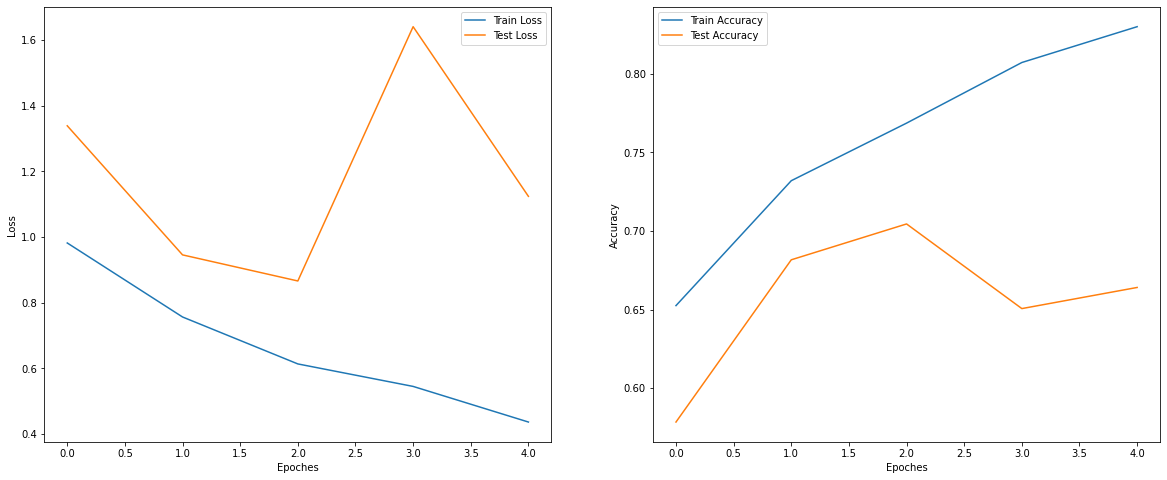


current exp | total: 7 | 16
Training with --- lr rate: 0.001, betas: (0.95, 0.9595), eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.9824 | Test Loss: 1.8018 | Train Accuray: 0.6545 | Test Accuracy: 0.5578
Epoch: 2  Train Loss: 0.7693 | Test Loss: 0.9196 | Train Accuray: 0.7246 | Test Accuracy: 0.6646
Epoch: 3  Train Loss: 0.6798 | Test Loss: 0.7408 | Train Accuray: 0.7567 | Test Accuracy: 0.7102
Epoch: 4  Train Loss: 0.5592 | Test Loss: 0.9710 | Train Accuray: 0.7941 | Test Accuracy: 0.7058
Epoch: 5  Train Loss: 0.5083 | Test Loss: 1.1901 | Train Accuray: 0.8131 | Test Accuracy: 0.6301


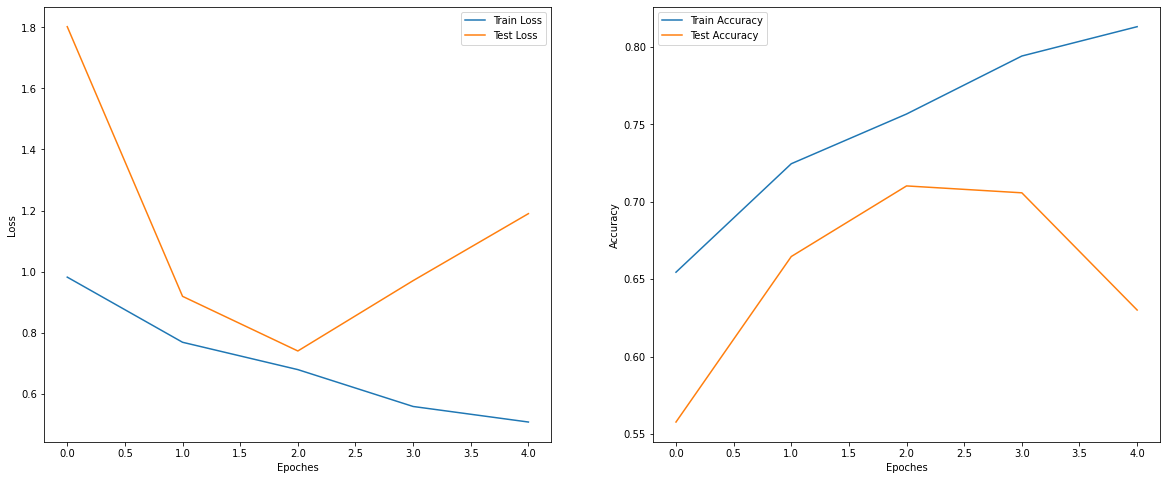


current exp | total: 8 | 16
Training with --- lr rate: 0.001, betas: (0.95, 0.9595), eps: 1e-07, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.9897 | Test Loss: 2.2028 | Train Accuray: 0.6538 | Test Accuracy: 0.4945
Epoch: 2  Train Loss: 0.7452 | Test Loss: 1.0483 | Train Accuray: 0.7362 | Test Accuracy: 0.6432
Epoch: 3  Train Loss: 0.6090 | Test Loss: 0.8112 | Train Accuray: 0.7728 | Test Accuracy: 0.7205
Epoch: 4  Train Loss: 0.5178 | Test Loss: 0.7550 | Train Accuray: 0.8099 | Test Accuracy: 0.7345
Epoch: 5  Train Loss: 0.4391 | Test Loss: 0.8380 | Train Accuray: 0.8361 | Test Accuracy: 0.7373


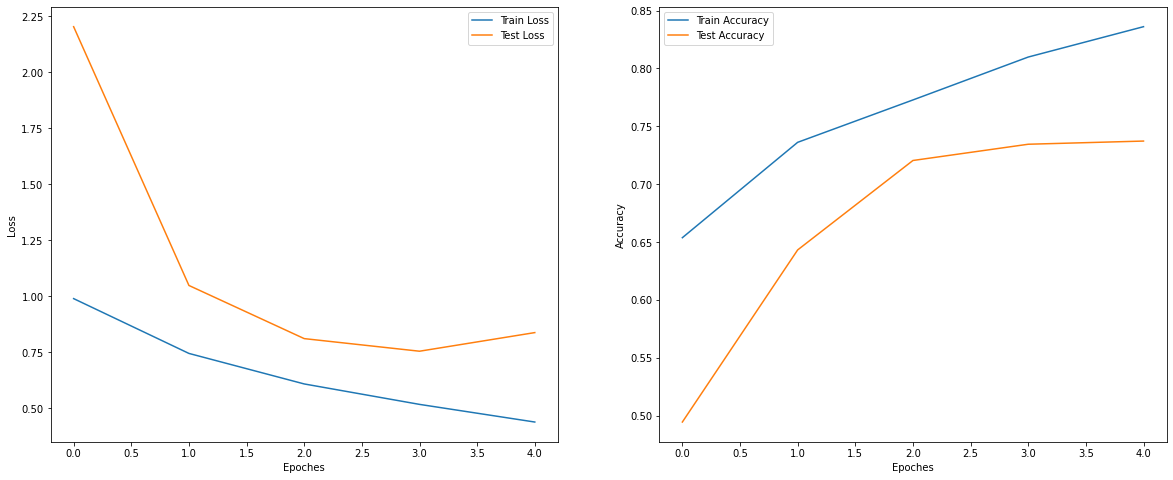


current exp | total: 9 | 16
Training with --- lr rate: 0.0001, betas: (0.85, 0.8585), eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4394 | Test Loss: 0.1936 | Train Accuray: 0.8405 | Test Accuracy: 0.9067
Epoch: 2  Train Loss: 0.0779 | Test Loss: 0.2028 | Train Accuray: 0.9520 | Test Accuracy: 0.9027
Epoch: 3  Train Loss: 0.0309 | Test Loss: 0.1885 | Train Accuray: 0.9555 | Test Accuracy: 0.9078
Epoch: 4  Train Loss: 0.0199 | Test Loss: 0.2065 | Train Accuray: 0.9617 | Test Accuracy: 0.9097
Epoch: 5  Train Loss: 0.0177 | Test Loss: 0.2529 | Train Accuray: 0.9590 | Test Accuracy: 0.9000


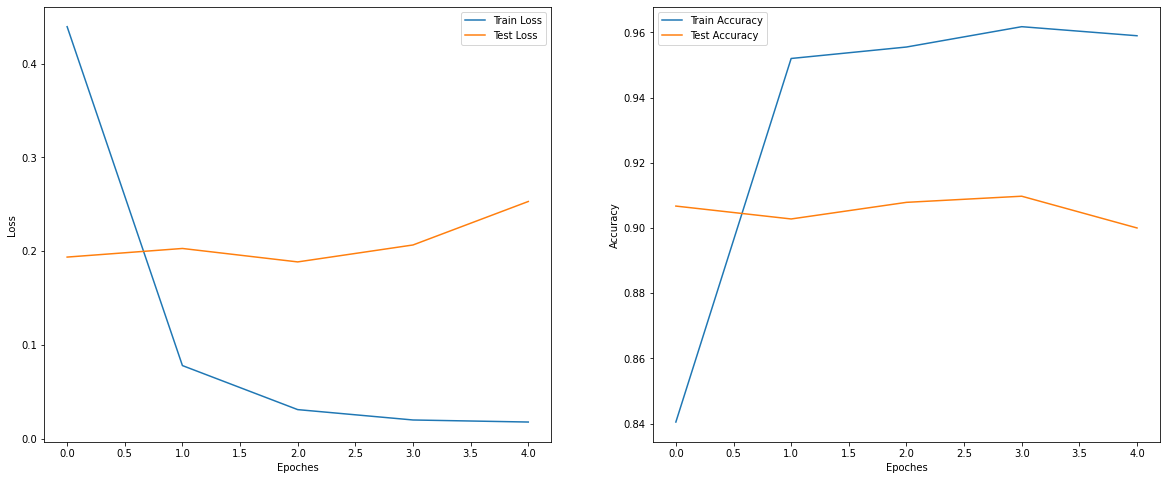


current exp | total: 10 | 16
Training with --- lr rate: 0.0001, betas: (0.85, 0.8585), eps: 1e-05, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4392 | Test Loss: 0.1939 | Train Accuray: 0.8392 | Test Accuracy: 0.9068
Epoch: 2  Train Loss: 0.0767 | Test Loss: 0.1989 | Train Accuray: 0.9519 | Test Accuracy: 0.9053
Epoch: 3  Train Loss: 0.0302 | Test Loss: 0.1969 | Train Accuray: 0.9550 | Test Accuracy: 0.9046
Epoch: 4  Train Loss: 0.0182 | Test Loss: 0.2101 | Train Accuray: 0.9627 | Test Accuracy: 0.9088
Epoch: 5  Train Loss: 0.0163 | Test Loss: 0.2066 | Train Accuray: 0.9577 | Test Accuracy: 0.9107


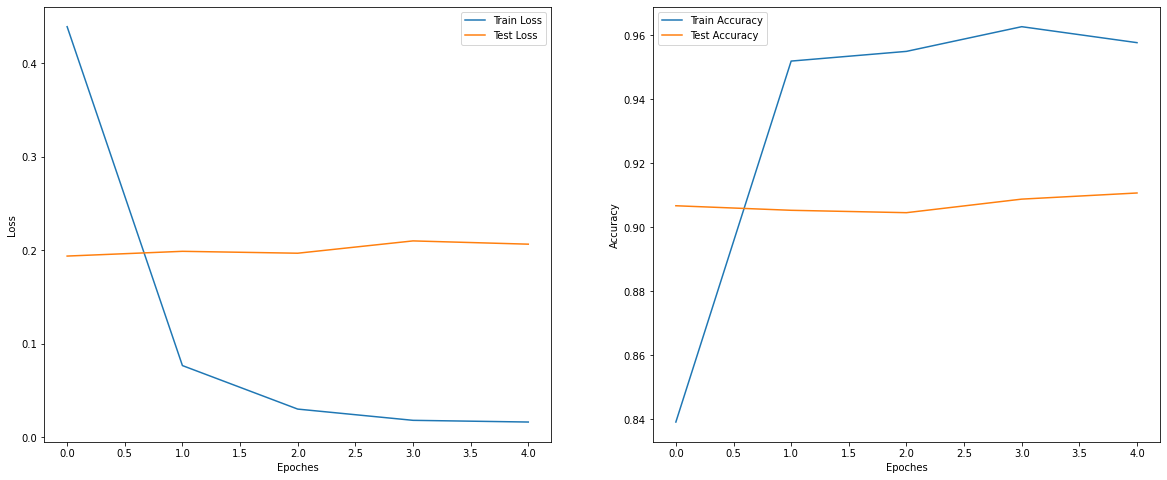


current exp | total: 11 | 16
Training with --- lr rate: 0.0001, betas: (0.85, 0.8585), eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4380 | Test Loss: 0.1903 | Train Accuray: 0.8402 | Test Accuracy: 0.9080
Epoch: 2  Train Loss: 0.0774 | Test Loss: 0.1981 | Train Accuray: 0.9506 | Test Accuracy: 0.9070
Epoch: 3  Train Loss: 0.0331 | Test Loss: 0.2036 | Train Accuray: 0.9536 | Test Accuracy: 0.9043
Epoch: 4  Train Loss: 0.0185 | Test Loss: 0.2697 | Train Accuray: 0.9633 | Test Accuracy: 0.8921
Epoch: 5  Train Loss: 0.0216 | Test Loss: 0.2161 | Train Accuray: 0.9563 | Test Accuracy: 0.9054


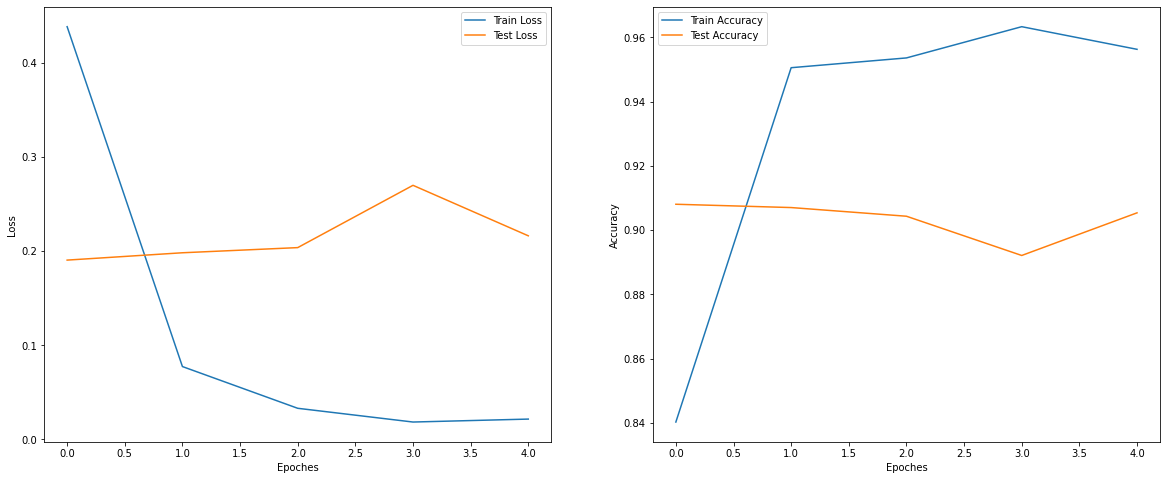


current exp | total: 12 | 16
Training with --- lr rate: 0.0001, betas: (0.85, 0.8585), eps: 1e-07, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4377 | Test Loss: 0.1909 | Train Accuray: 0.8394 | Test Accuracy: 0.9069
Epoch: 2  Train Loss: 0.0753 | Test Loss: 0.2100 | Train Accuray: 0.9524 | Test Accuracy: 0.9032
Epoch: 3  Train Loss: 0.0340 | Test Loss: 0.2027 | Train Accuray: 0.9531 | Test Accuracy: 0.9048
Epoch: 4  Train Loss: 0.0178 | Test Loss: 0.2317 | Train Accuray: 0.9623 | Test Accuracy: 0.9051
Epoch: 5  Train Loss: 0.0150 | Test Loss: 0.2174 | Train Accuray: 0.9594 | Test Accuracy: 0.9047


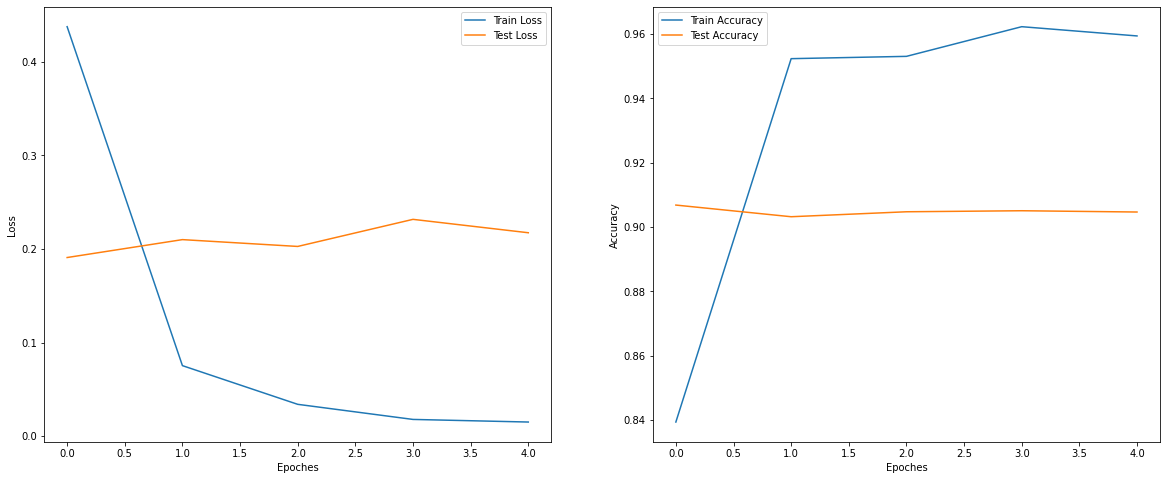


current exp | total: 13 | 16
Training with --- lr rate: 0.0001, betas: (0.95, 0.9595), eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4441 | Test Loss: 0.2015 | Train Accuray: 0.8418 | Test Accuracy: 0.9066
Epoch: 2  Train Loss: 0.0778 | Test Loss: 0.1872 | Train Accuray: 0.9519 | Test Accuracy: 0.9070
Epoch: 3  Train Loss: 0.0379 | Test Loss: 0.1927 | Train Accuray: 0.9541 | Test Accuracy: 0.9086
Epoch: 4  Train Loss: 0.0246 | Test Loss: 0.2160 | Train Accuray: 0.9608 | Test Accuracy: 0.9037
Epoch: 5  Train Loss: 0.0247 | Test Loss: 0.2346 | Train Accuray: 0.9569 | Test Accuracy: 0.8967


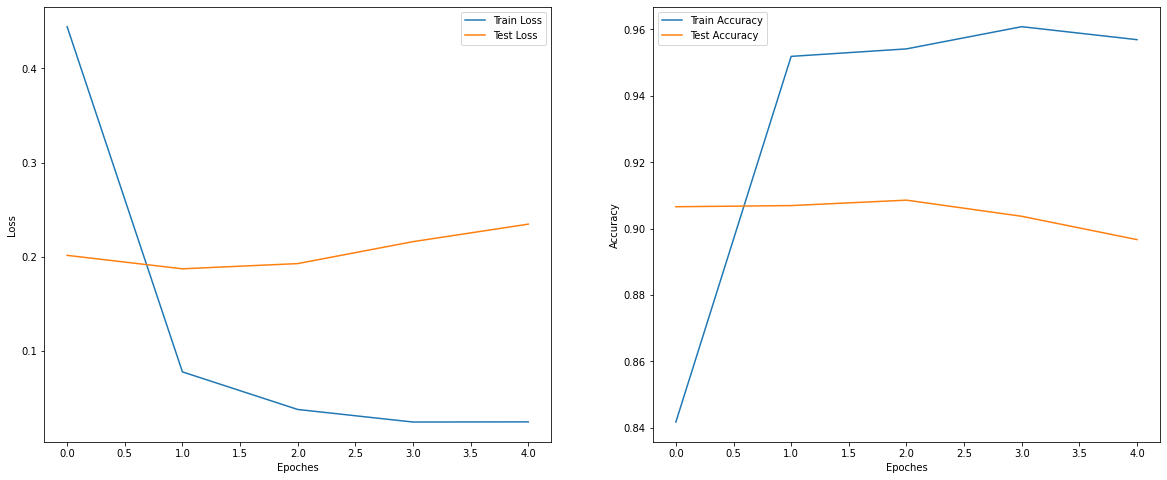


current exp | total: 14 | 16
Training with --- lr rate: 0.0001, betas: (0.95, 0.9595), eps: 1e-05, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4443 | Test Loss: 0.2025 | Train Accuray: 0.8416 | Test Accuracy: 0.9069
Epoch: 2  Train Loss: 0.0768 | Test Loss: 0.1898 | Train Accuray: 0.9519 | Test Accuracy: 0.9068
Epoch: 3  Train Loss: 0.0356 | Test Loss: 0.1982 | Train Accuray: 0.9544 | Test Accuracy: 0.9067
Epoch: 4  Train Loss: 0.0231 | Test Loss: 0.1883 | Train Accuray: 0.9609 | Test Accuracy: 0.9101
Epoch: 5  Train Loss: 0.0237 | Test Loss: 0.2311 | Train Accuray: 0.9569 | Test Accuracy: 0.9047


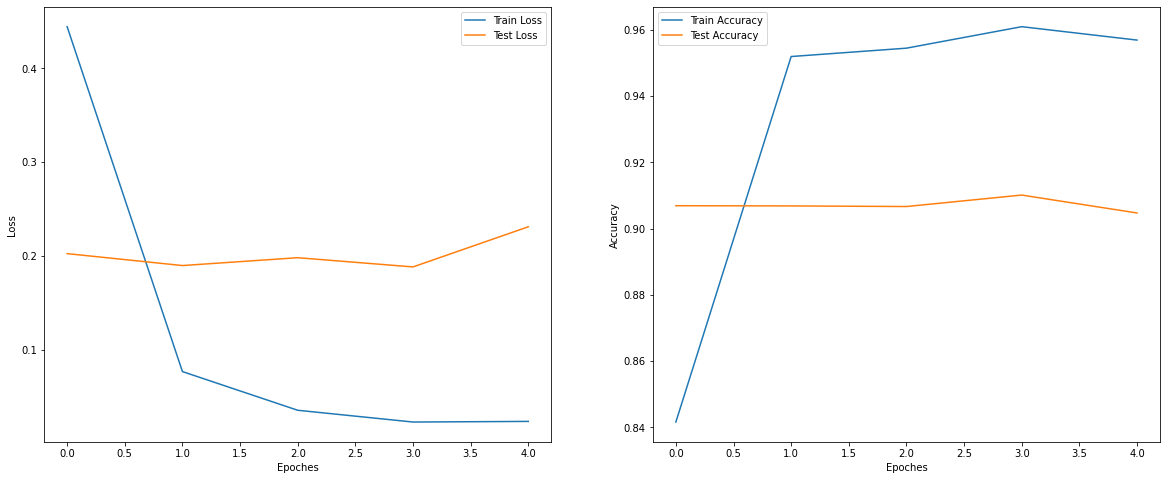


current exp | total: 15 | 16
Training with --- lr rate: 0.0001, betas: (0.95, 0.9595), eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4425 | Test Loss: 0.2007 | Train Accuray: 0.8416 | Test Accuracy: 0.9077
Epoch: 2  Train Loss: 0.0781 | Test Loss: 0.1887 | Train Accuray: 0.9510 | Test Accuracy: 0.9090
Epoch: 3  Train Loss: 0.0361 | Test Loss: 0.1969 | Train Accuray: 0.9537 | Test Accuracy: 0.9052
Epoch: 4  Train Loss: 0.0255 | Test Loss: 0.2081 | Train Accuray: 0.9614 | Test Accuracy: 0.9103
Epoch: 5  Train Loss: 0.0290 | Test Loss: 0.2537 | Train Accuray: 0.9542 | Test Accuracy: 0.9001


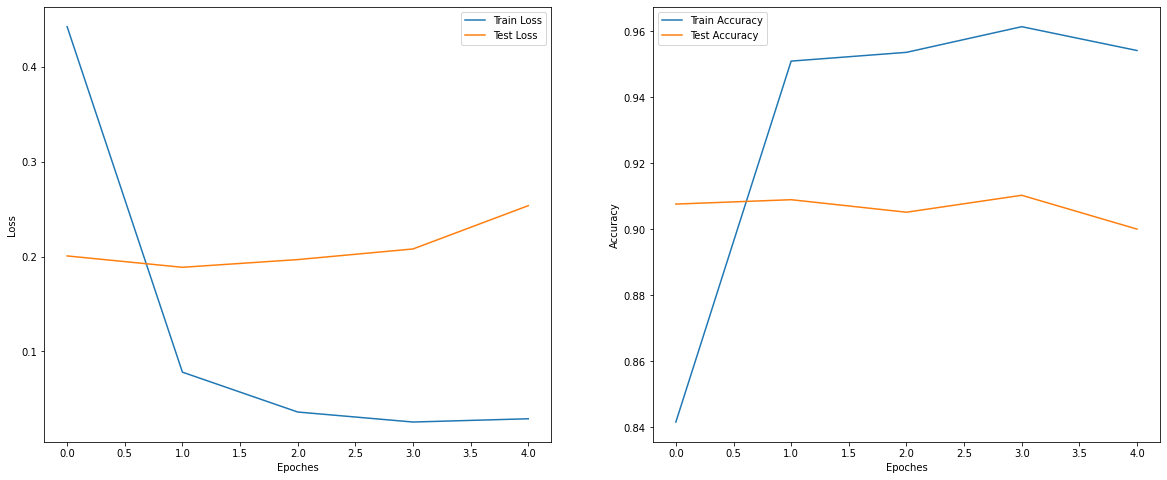


current exp | total: 16 | 16
Training with --- lr rate: 0.0001, betas: (0.95, 0.9595), eps: 1e-07, weight decay: 0.0005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.4434 | Test Loss: 0.2001 | Train Accuray: 0.8429 | Test Accuracy: 0.9061
Epoch: 2  Train Loss: 0.0783 | Test Loss: 0.1926 | Train Accuray: 0.9514 | Test Accuracy: 0.9070
Epoch: 3  Train Loss: 0.0352 | Test Loss: 0.1958 | Train Accuray: 0.9538 | Test Accuracy: 0.9062
Epoch: 4  Train Loss: 0.0214 | Test Loss: 0.2276 | Train Accuray: 0.9611 | Test Accuracy: 0.9032
Epoch: 5  Train Loss: 0.0285 | Test Loss: 0.2251 | Train Accuray: 0.9532 | Test Accuracy: 0.9025


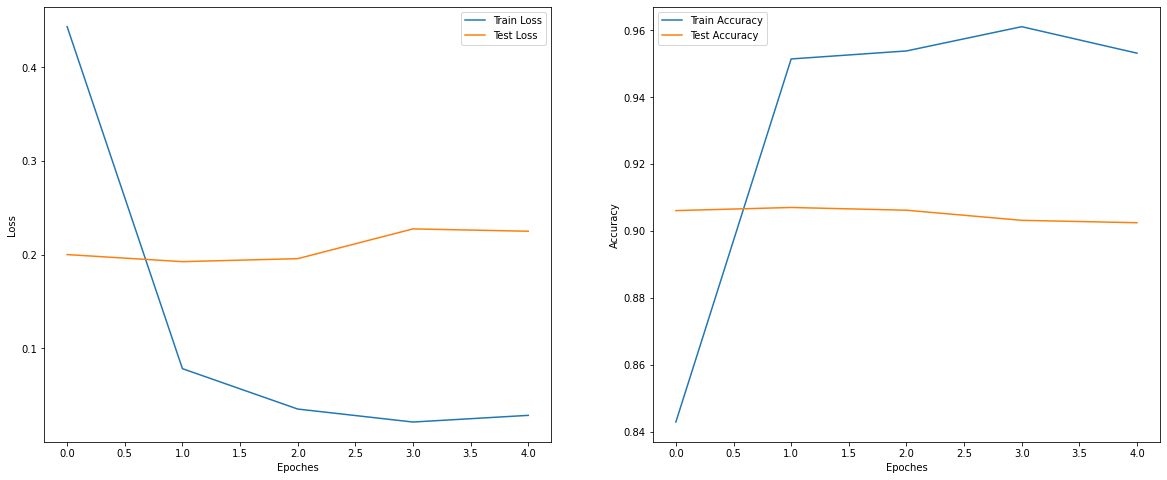

In [ ]:
# Hyperparameter
lr_rate = [0.001,0.0001] # learning rate
betas=[(0.85, 0.8585),(0.95, 0.9595)] # coefficients used for computing running averages of gradient and its square
eps = [1e-5,1e-7] # term added to the denominator to improve numerical stability
weight_decay = [0.001,0.0005] # weight decay (L2 penalty)

hyper_params = [(lr,b,e,wd) for lr in lr_rate for b in betas for e in eps for wd in weight_decay]
# print(parms_combs)

cur_iter,total_iter = 1, len(lr_rate)*len(betas)*len(eps)*len(weight_decay)

# init. epochs
epoches = 5

for h_p in hyper_params:
  print()
  print(f"current exp | total: {cur_iter} | {total_iter}")
  print(f"Training with --- lr rate: {h_p[0]}, betas: {h_p[1]}, eps: {h_p[2]}, weight decay: {h_p[3]}")
  model_18 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1).to(device)
  feature_number = model_18.fc.in_features
  model_18.fc = nn.Linear(feature_number, len(class_names)).to(device)

  optimizer = torch.optim.Adam(params=model_18.parameters(), lr=h_p[0], betas=h_p[1], eps=h_p[2],weight_decay=h_p[3])
  model18_train_loss, model18_test_loss = [], []
  model18_train_accs, model18_test_accs = [], []

  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  for epoch in tqdm(range(epoches)):

    train_loss, train_acc = train_loop(model = model_18, dataloader = train_dataloader,
                                      loss_fn = loss_fn, optimizer = optimizer,
                                      accuracy_fn = accuracy_fn, device = device)
    
    test_loss, test_acc = test_loop(model = model_18, dataloader = test_dataloader,
                                    loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                    device = device)
    
    model18_train_loss.append(train_loss.item())
    model18_test_loss.append(test_loss.item())
    model18_train_accs.append(train_acc.item())
    model18_test_accs.append(test_acc.item())

    print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
  cur_iter += 1
  plot_graph(model18_train_loss, model18_test_loss, model18_train_accs, model18_test_accs)


# Train model on Adadelta


current exp | total: 1 | 16
Training with --- lr rate: 0.01, rho: 0.75, eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.0812 | Test Loss: 0.4375 | Train Accuray: 0.7103 | Test Accuracy: 0.8855
Epoch: 2  Train Loss: 0.3490 | Test Loss: 0.2676 | Train Accuray: 0.9002 | Test Accuracy: 0.9046
Epoch: 3  Train Loss: 0.2162 | Test Loss: 0.2141 | Train Accuray: 0.9236 | Test Accuracy: 0.9098
Epoch: 4  Train Loss: 0.1450 | Test Loss: 0.1824 | Train Accuray: 0.9385 | Test Accuracy: 0.9155
Epoch: 5  Train Loss: 0.0986 | Test Loss: 0.1679 | Train Accuray: 0.9468 | Test Accuracy: 0.9164


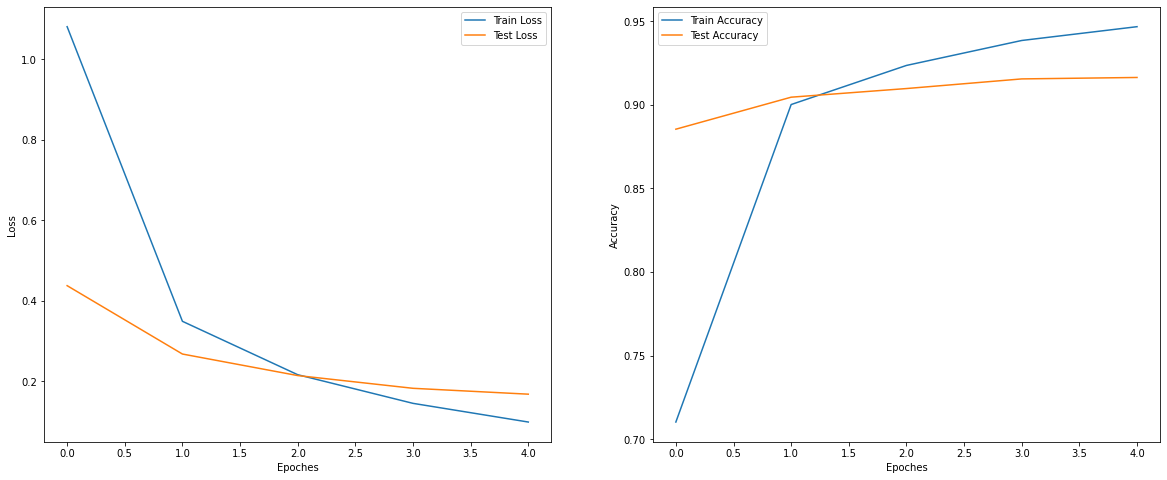


current exp | total: 2 | 16
Training with --- lr rate: 0.01, rho: 0.75, eps: 1e-05, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.0854 | Test Loss: 0.4638 | Train Accuray: 0.6958 | Test Accuracy: 0.8768
Epoch: 2  Train Loss: 0.3673 | Test Loss: 0.2801 | Train Accuray: 0.8965 | Test Accuracy: 0.8989
Epoch: 3  Train Loss: 0.2230 | Test Loss: 0.2154 | Train Accuray: 0.9213 | Test Accuracy: 0.9059
Epoch: 4  Train Loss: 0.1497 | Test Loss: 0.1866 | Train Accuray: 0.9359 | Test Accuracy: 0.9103
Epoch: 5  Train Loss: 0.1026 | Test Loss: 0.1678 | Train Accuray: 0.9459 | Test Accuracy: 0.9148


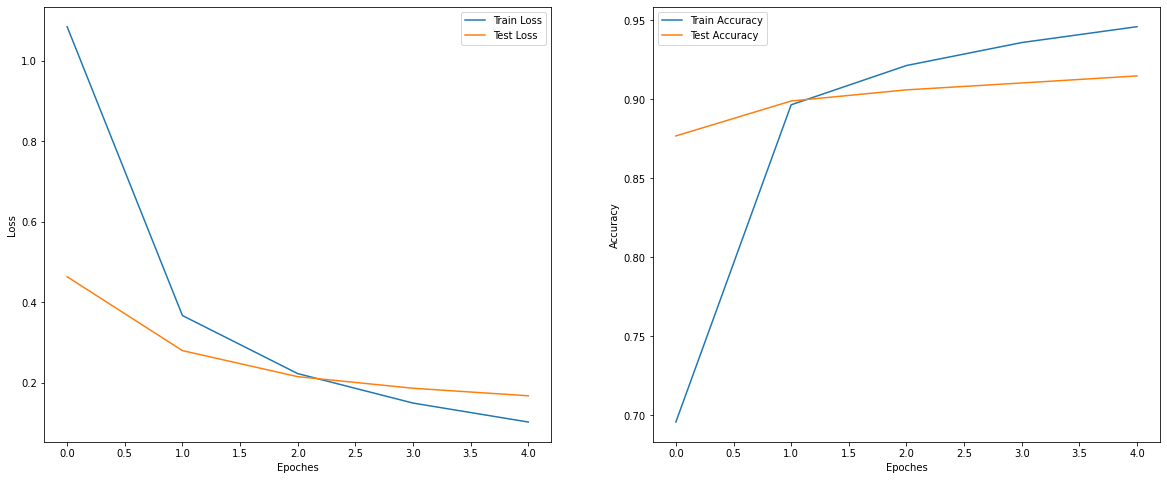


current exp | total: 3 | 16
Training with --- lr rate: 0.01, rho: 0.75, eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.7516 | Test Loss: 1.1672 | Train Accuray: 0.4112 | Test Accuracy: 0.7162
Epoch: 2  Train Loss: 0.9112 | Test Loss: 0.6633 | Train Accuray: 0.8040 | Test Accuracy: 0.8501
Epoch: 3  Train Loss: 0.5705 | Test Loss: 0.4518 | Train Accuray: 0.8654 | Test Accuracy: 0.8752
Epoch: 4  Train Loss: 0.4142 | Test Loss: 0.3541 | Train Accuray: 0.8897 | Test Accuracy: 0.8908
Epoch: 5  Train Loss: 0.3163 | Test Loss: 0.2960 | Train Accuray: 0.9073 | Test Accuracy: 0.8968


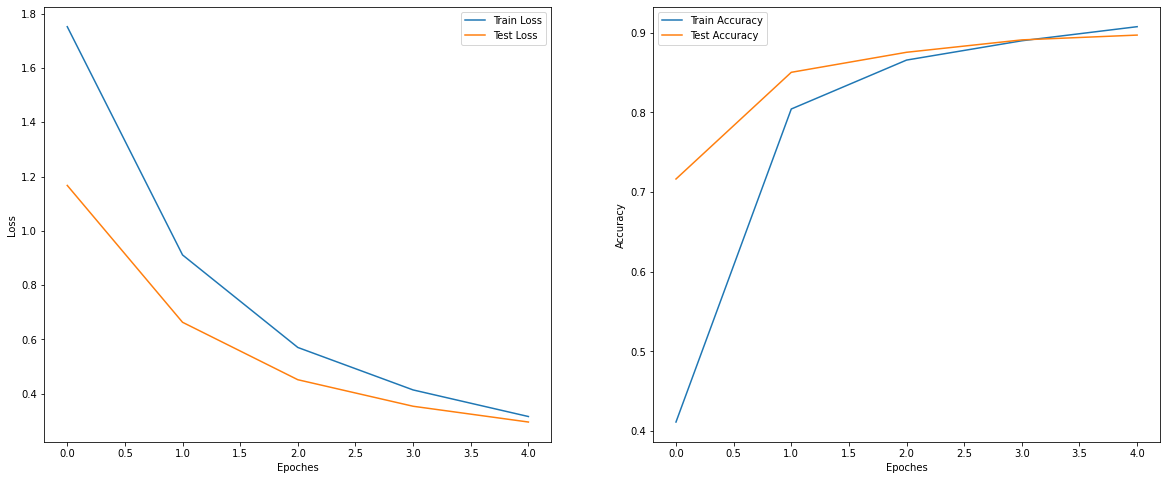


current exp | total: 4 | 16
Training with --- lr rate: 0.01, rho: 0.75, eps: 1e-07, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.7516 | Test Loss: 1.1671 | Train Accuray: 0.4120 | Test Accuracy: 0.7160
Epoch: 2  Train Loss: 0.9111 | Test Loss: 0.6632 | Train Accuray: 0.8046 | Test Accuracy: 0.8493
Epoch: 3  Train Loss: 0.5705 | Test Loss: 0.4517 | Train Accuray: 0.8654 | Test Accuracy: 0.8751
Epoch: 4  Train Loss: 0.4141 | Test Loss: 0.3540 | Train Accuray: 0.8897 | Test Accuracy: 0.8907
Epoch: 5  Train Loss: 0.3162 | Test Loss: 0.2960 | Train Accuray: 0.9071 | Test Accuracy: 0.8967


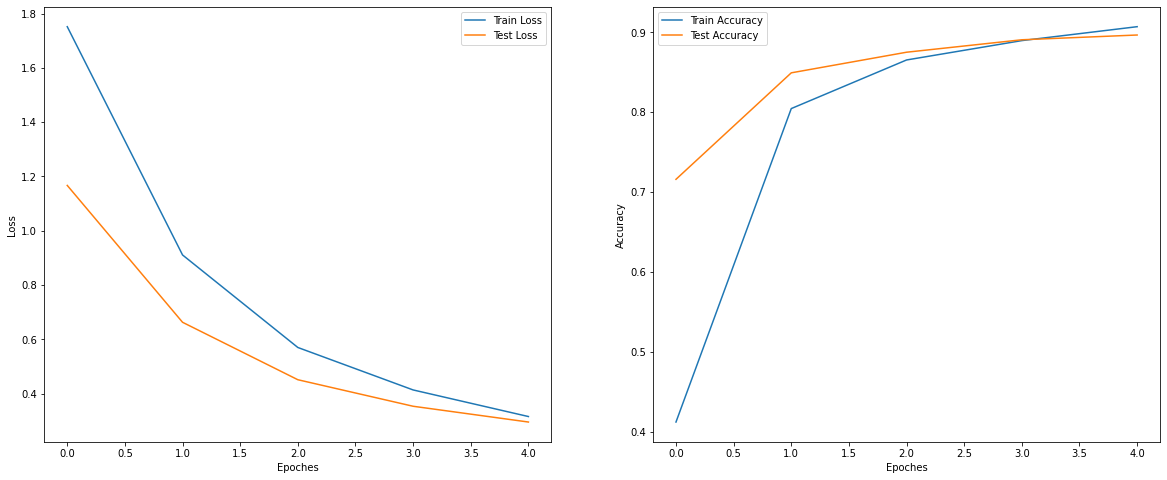


current exp | total: 5 | 16
Training with --- lr rate: 0.01, rho: 0.85, eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.0622 | Test Loss: 0.4509 | Train Accuray: 0.7021 | Test Accuracy: 0.8802
Epoch: 2  Train Loss: 0.3564 | Test Loss: 0.2688 | Train Accuray: 0.8983 | Test Accuracy: 0.9030
Epoch: 3  Train Loss: 0.2156 | Test Loss: 0.2112 | Train Accuray: 0.9222 | Test Accuracy: 0.9064
Epoch: 4  Train Loss: 0.1437 | Test Loss: 0.1832 | Train Accuray: 0.9387 | Test Accuracy: 0.9133
Epoch: 5  Train Loss: 0.0977 | Test Loss: 0.1655 | Train Accuray: 0.9467 | Test Accuracy: 0.9150


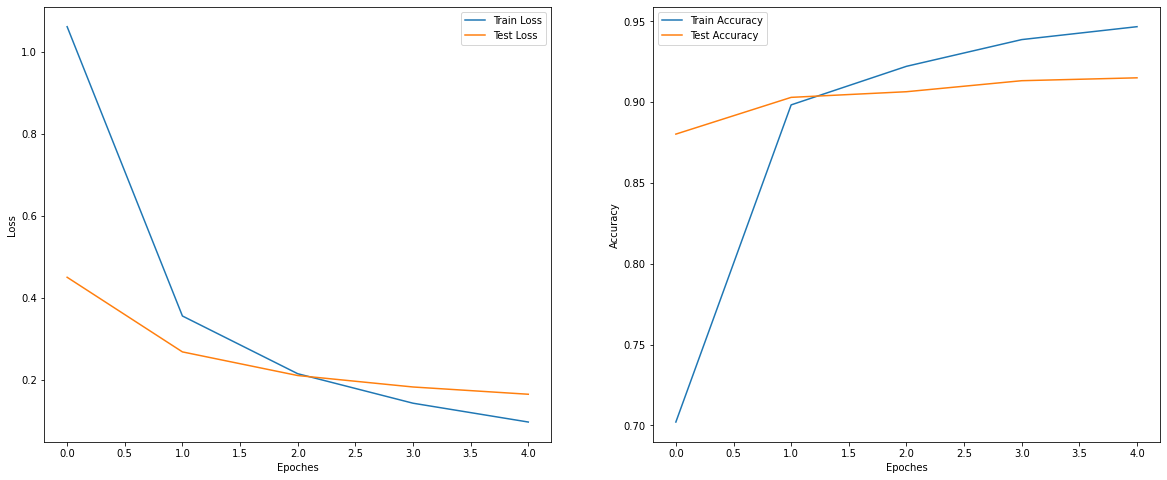


current exp | total: 6 | 16
Training with --- lr rate: 0.01, rho: 0.85, eps: 1e-05, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.0620 | Test Loss: 0.4508 | Train Accuray: 0.7050 | Test Accuracy: 0.8787
Epoch: 2  Train Loss: 0.3564 | Test Loss: 0.2710 | Train Accuray: 0.8972 | Test Accuracy: 0.9019
Epoch: 3  Train Loss: 0.2153 | Test Loss: 0.2106 | Train Accuray: 0.9212 | Test Accuracy: 0.9070
Epoch: 4  Train Loss: 0.1433 | Test Loss: 0.1827 | Train Accuray: 0.9387 | Test Accuracy: 0.9117
Epoch: 5  Train Loss: 0.0977 | Test Loss: 0.1661 | Train Accuray: 0.9465 | Test Accuracy: 0.9146


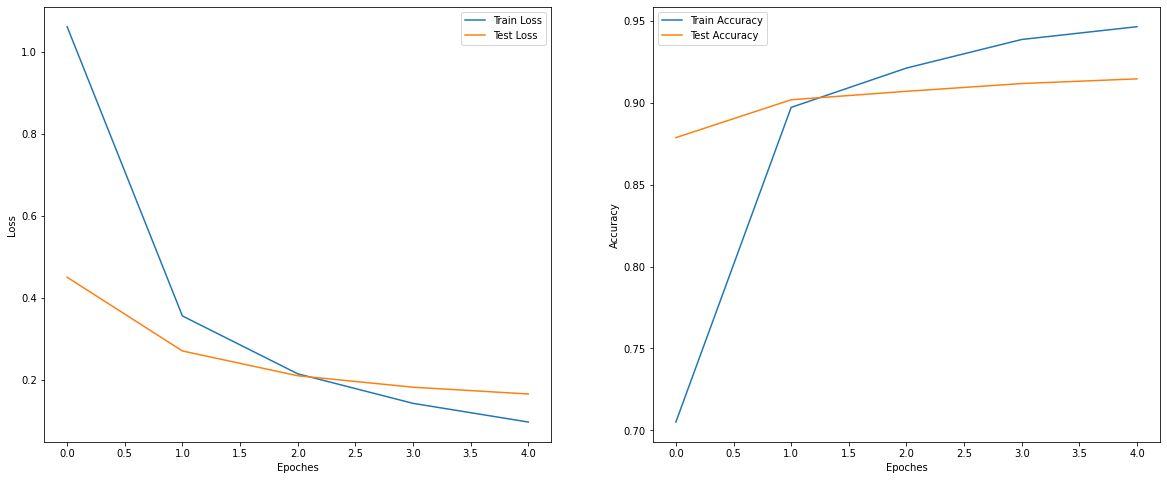


current exp | total: 7 | 16
Training with --- lr rate: 0.01, rho: 0.85, eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.6798 | Test Loss: 1.0677 | Train Accuray: 0.4528 | Test Accuracy: 0.7509
Epoch: 2  Train Loss: 0.8274 | Test Loss: 0.5944 | Train Accuray: 0.8243 | Test Accuracy: 0.8585
Epoch: 3  Train Loss: 0.5123 | Test Loss: 0.4084 | Train Accuray: 0.8758 | Test Accuracy: 0.8817
Epoch: 4  Train Loss: 0.3720 | Test Loss: 0.3240 | Train Accuray: 0.8968 | Test Accuracy: 0.8946
Epoch: 5  Train Loss: 0.2832 | Test Loss: 0.2742 | Train Accuray: 0.9137 | Test Accuracy: 0.8993


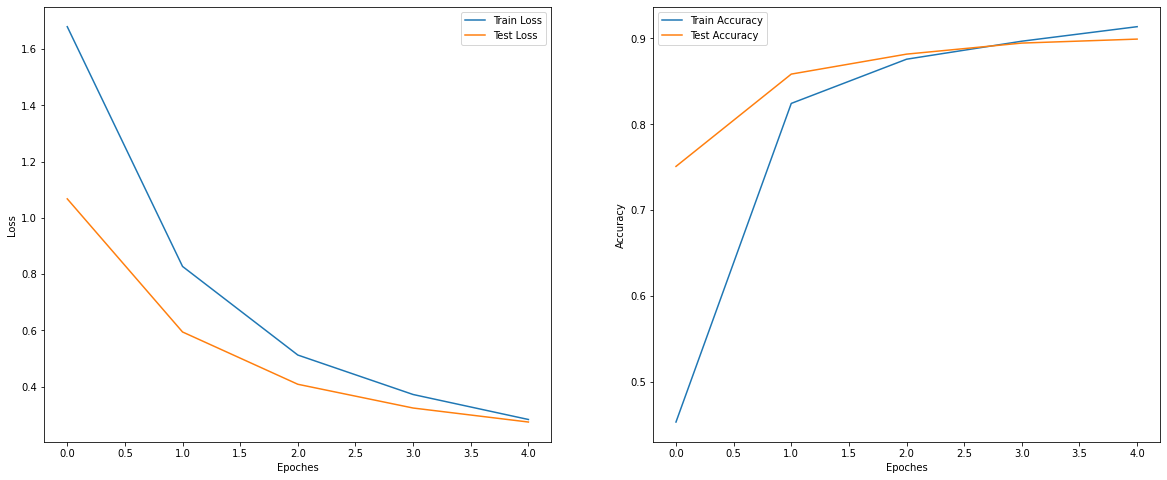


current exp | total: 8 | 16
Training with --- lr rate: 0.01, rho: 0.85, eps: 1e-07, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.6797 | Test Loss: 1.0678 | Train Accuray: 0.4528 | Test Accuracy: 0.7506
Epoch: 2  Train Loss: 0.8273 | Test Loss: 0.5944 | Train Accuray: 0.8250 | Test Accuracy: 0.8587
Epoch: 3  Train Loss: 0.5123 | Test Loss: 0.4084 | Train Accuray: 0.8760 | Test Accuracy: 0.8817
Epoch: 4  Train Loss: 0.3720 | Test Loss: 0.3239 | Train Accuray: 0.8967 | Test Accuracy: 0.8944
Epoch: 5  Train Loss: 0.2831 | Test Loss: 0.2741 | Train Accuray: 0.9140 | Test Accuracy: 0.8987


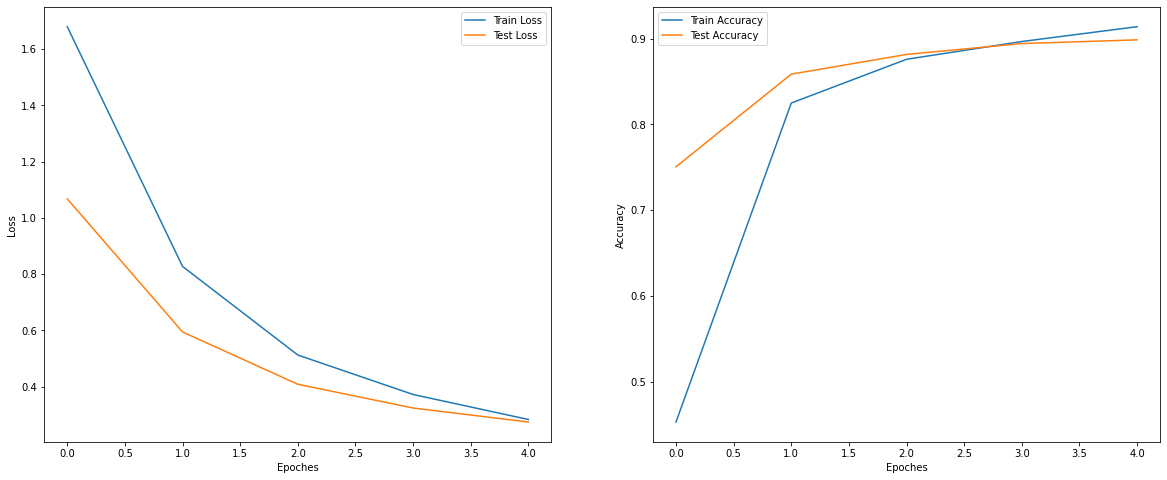


current exp | total: 9 | 16
Training with --- lr rate: 0.001, rho: 0.75, eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.1457 | Test Loss: 1.8740 | Train Accuray: 0.2118 | Test Accuracy: 0.3441
Epoch: 2  Train Loss: 1.6718 | Test Loss: 1.4678 | Train Accuray: 0.4897 | Test Accuracy: 0.5998
Epoch: 3  Train Loss: 1.3378 | Test Loss: 1.1768 | Train Accuray: 0.6764 | Test Accuracy: 0.7311
Epoch: 4  Train Loss: 1.1035 | Test Loss: 0.9761 | Train Accuray: 0.7638 | Test Accuracy: 0.7941
Epoch: 5  Train Loss: 0.9230 | Test Loss: 0.8254 | Train Accuray: 0.8048 | Test Accuracy: 0.8297


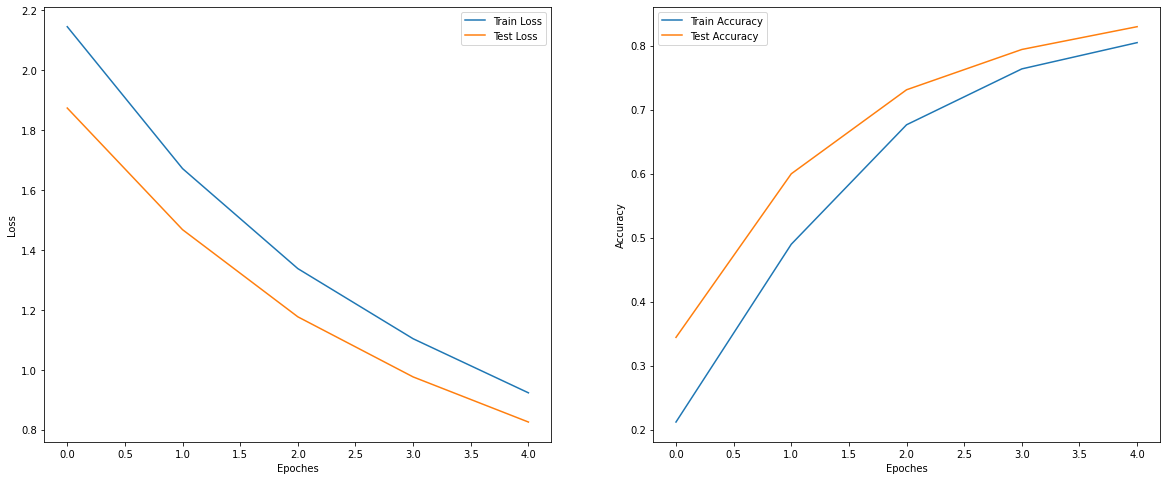


current exp | total: 10 | 16
Training with --- lr rate: 0.001, rho: 0.75, eps: 1e-05, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.1457 | Test Loss: 1.8740 | Train Accuray: 0.2115 | Test Accuracy: 0.3441
Epoch: 2  Train Loss: 1.6718 | Test Loss: 1.4678 | Train Accuray: 0.4897 | Test Accuracy: 0.5994
Epoch: 3  Train Loss: 1.3377 | Test Loss: 1.1767 | Train Accuray: 0.6765 | Test Accuracy: 0.7311
Epoch: 4  Train Loss: 1.1034 | Test Loss: 0.9759 | Train Accuray: 0.7642 | Test Accuracy: 0.7940
Epoch: 5  Train Loss: 0.9229 | Test Loss: 0.8253 | Train Accuray: 0.8044 | Test Accuracy: 0.8297


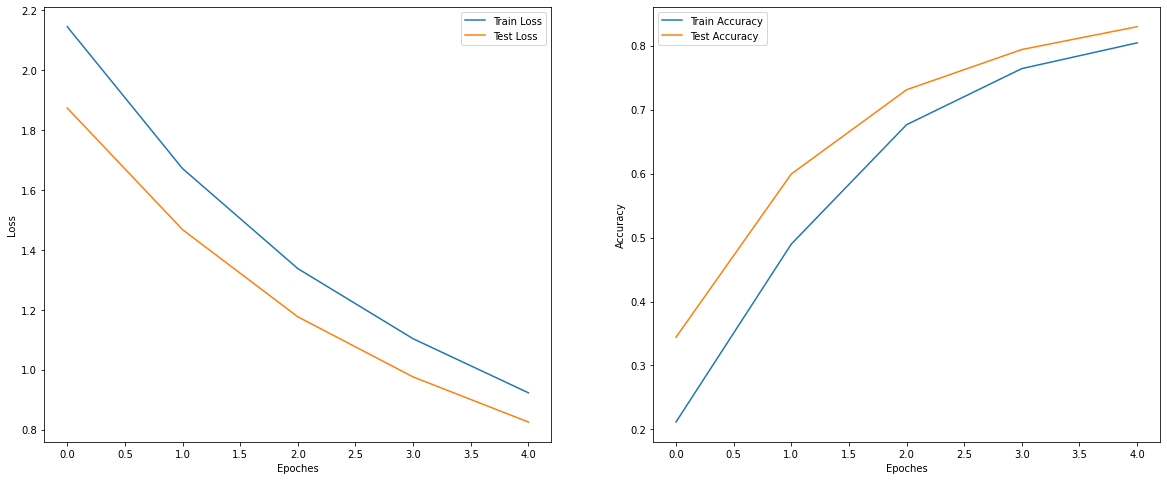


current exp | total: 11 | 16
Training with --- lr rate: 0.001, rho: 0.75, eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.3387 | Test Loss: 2.2574 | Train Accuray: 0.1342 | Test Accuracy: 0.1507
Epoch: 2  Train Loss: 2.1688 | Test Loss: 2.0924 | Train Accuray: 0.1867 | Test Accuracy: 0.2145
Epoch: 3  Train Loss: 2.0156 | Test Loss: 1.9396 | Train Accuray: 0.2546 | Test Accuracy: 0.2875
Epoch: 4  Train Loss: 1.8745 | Test Loss: 1.7970 | Train Accuray: 0.3338 | Test Accuracy: 0.3706
Epoch: 5  Train Loss: 1.7366 | Test Loss: 1.6719 | Train Accuray: 0.4205 | Test Accuracy: 0.4376


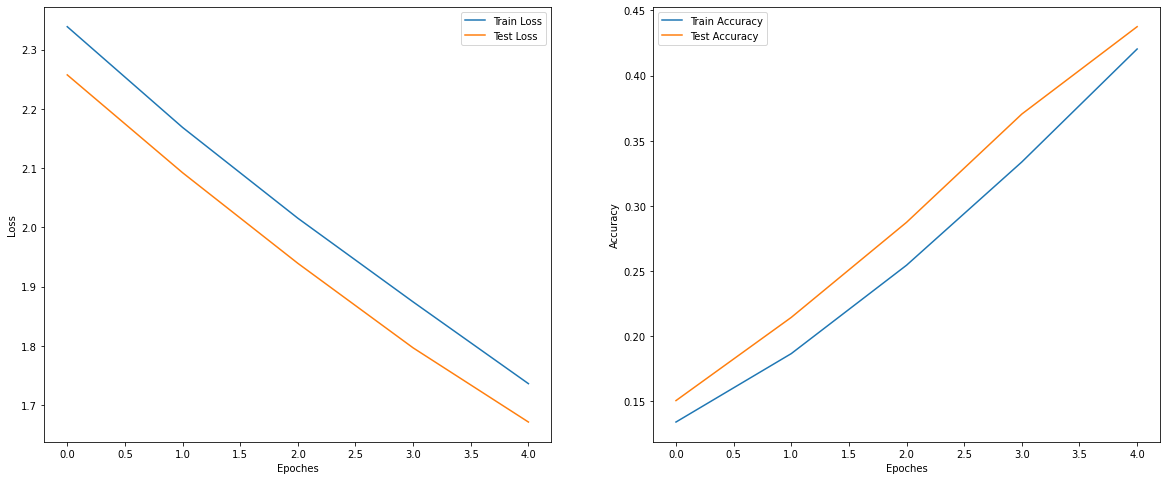


current exp | total: 12 | 16
Training with --- lr rate: 0.001, rho: 0.75, eps: 1e-07, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.3387 | Test Loss: 2.2574 | Train Accuray: 0.1342 | Test Accuracy: 0.1507
Epoch: 2  Train Loss: 2.1688 | Test Loss: 2.0924 | Train Accuray: 0.1867 | Test Accuracy: 0.2145
Epoch: 3  Train Loss: 2.0156 | Test Loss: 1.9396 | Train Accuray: 0.2546 | Test Accuracy: 0.2873
Epoch: 4  Train Loss: 1.8744 | Test Loss: 1.7969 | Train Accuray: 0.3338 | Test Accuracy: 0.3706
Epoch: 5  Train Loss: 1.7366 | Test Loss: 1.6718 | Train Accuray: 0.4205 | Test Accuracy: 0.4376


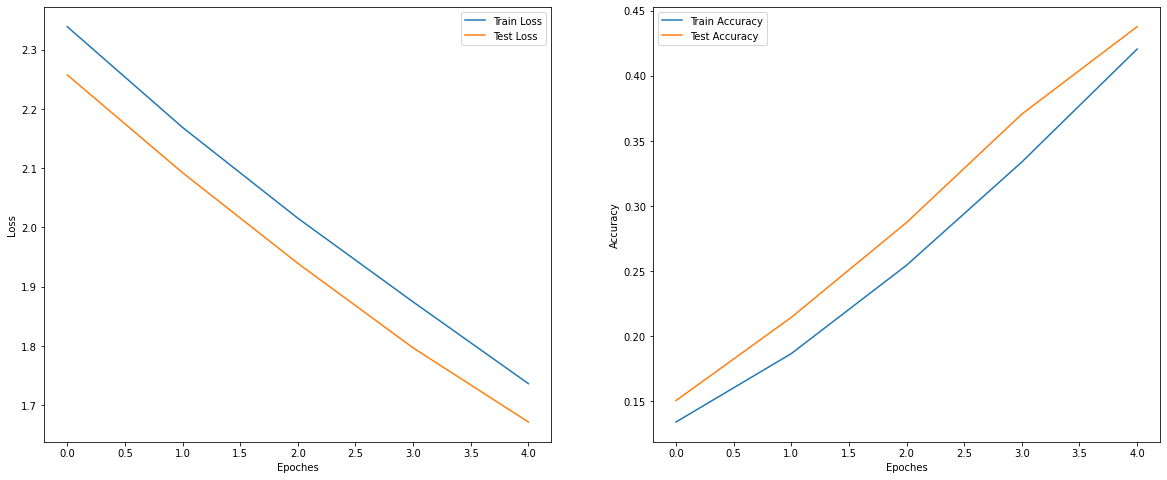


current exp | total: 13 | 16
Training with --- lr rate: 0.001, rho: 0.85, eps: 1e-05, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.1330 | Test Loss: 1.8513 | Train Accuray: 0.2167 | Test Accuracy: 0.3623
Epoch: 2  Train Loss: 1.6446 | Test Loss: 1.4355 | Train Accuray: 0.5133 | Test Accuracy: 0.6219
Epoch: 3  Train Loss: 1.3051 | Test Loss: 1.1421 | Train Accuray: 0.6928 | Test Accuracy: 0.7456
Epoch: 4  Train Loss: 1.0702 | Test Loss: 0.9422 | Train Accuray: 0.7759 | Test Accuracy: 0.8026
Epoch: 5  Train Loss: 0.8908 | Test Loss: 0.7934 | Train Accuray: 0.8113 | Test Accuracy: 0.8346


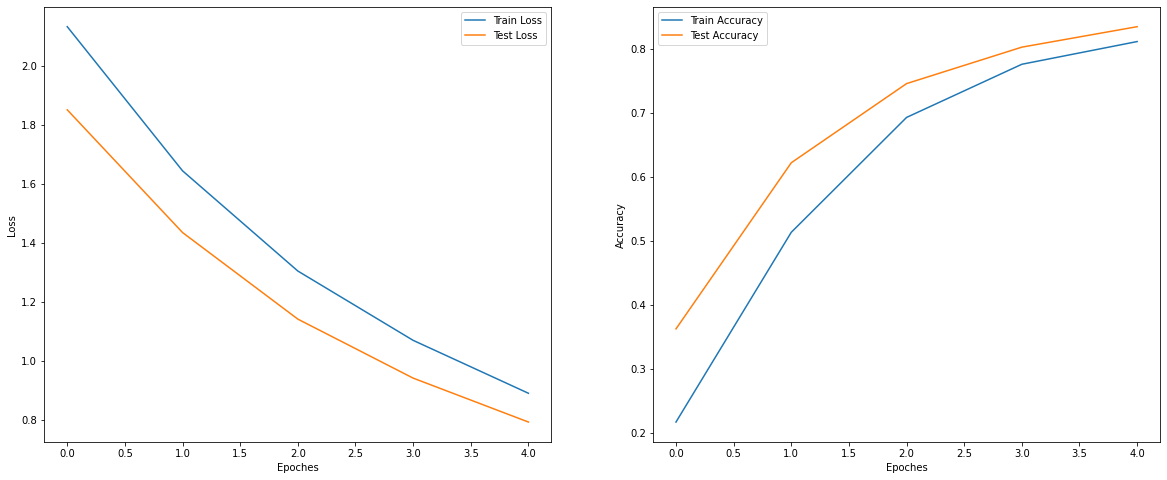


current exp | total: 14 | 16
Training with --- lr rate: 0.001, rho: 0.85, eps: 1e-05, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.1330 | Test Loss: 1.8513 | Train Accuray: 0.2168 | Test Accuracy: 0.3623
Epoch: 2  Train Loss: 1.6446 | Test Loss: 1.4354 | Train Accuray: 0.5134 | Test Accuracy: 0.6222
Epoch: 3  Train Loss: 1.3050 | Test Loss: 1.1420 | Train Accuray: 0.6927 | Test Accuracy: 0.7455
Epoch: 4  Train Loss: 1.0701 | Test Loss: 0.9421 | Train Accuray: 0.7761 | Test Accuracy: 0.8028
Epoch: 5  Train Loss: 0.8907 | Test Loss: 0.7932 | Train Accuray: 0.8118 | Test Accuracy: 0.8347


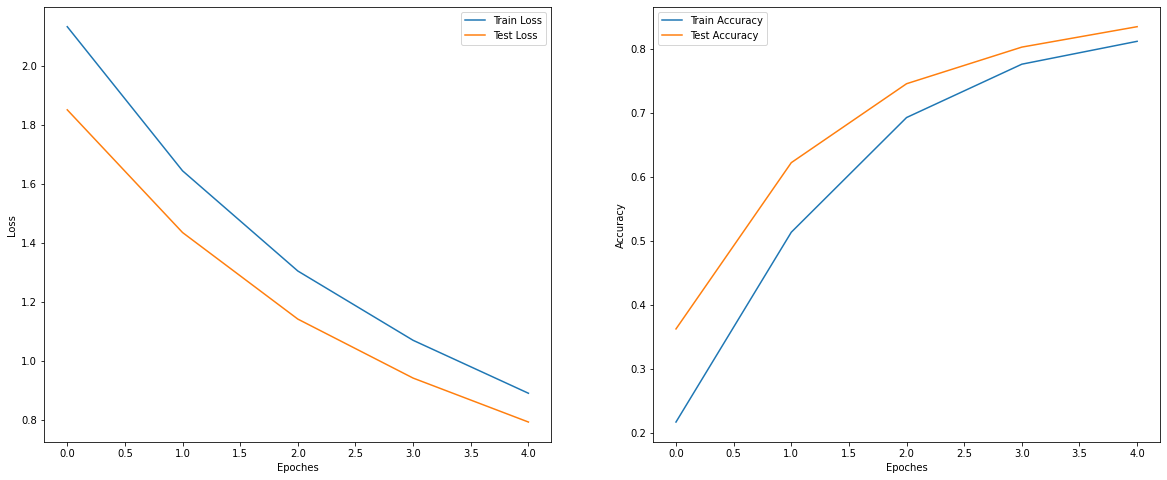


current exp | total: 15 | 16
Training with --- lr rate: 0.001, rho: 0.85, eps: 1e-07, weight decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.3261 | Test Loss: 2.2317 | Train Accuray: 0.1374 | Test Accuracy: 0.1596
Epoch: 2  Train Loss: 2.1333 | Test Loss: 2.0451 | Train Accuray: 0.2002 | Test Accuracy: 0.2356
Epoch: 3  Train Loss: 1.9605 | Test Loss: 1.8733 | Train Accuray: 0.2874 | Test Accuracy: 0.3244
Epoch: 4  Train Loss: 1.8032 | Test Loss: 1.7167 | Train Accuray: 0.3752 | Test Accuracy: 0.4175
Epoch: 5  Train Loss: 1.6523 | Test Loss: 1.5799 | Train Accuray: 0.4737 | Test Accuracy: 0.4916


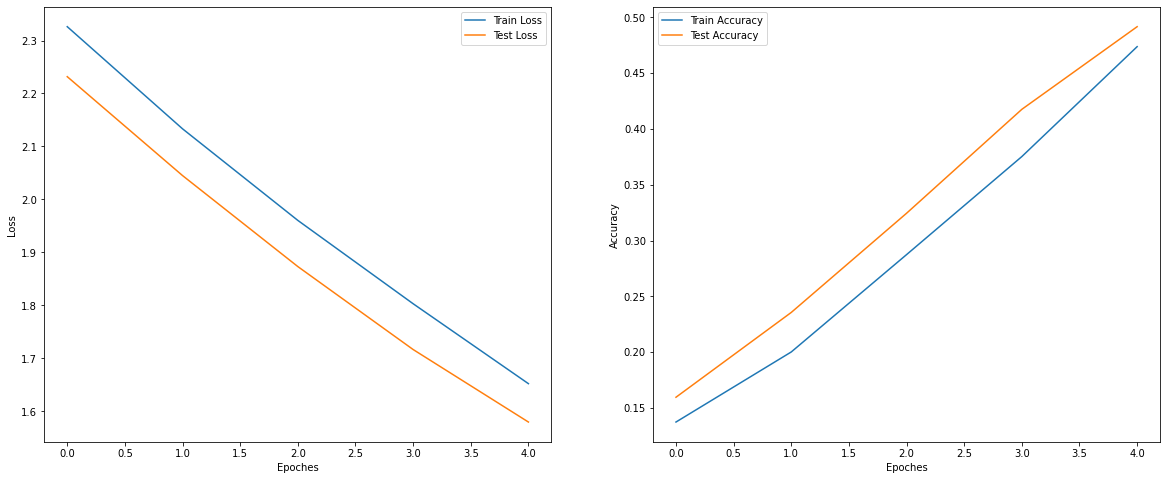


current exp | total: 16 | 16
Training with --- lr rate: 0.001, rho: 0.85, eps: 1e-07, weight decay: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.3261 | Test Loss: 2.2317 | Train Accuray: 0.1374 | Test Accuracy: 0.1596
Epoch: 2  Train Loss: 2.1333 | Test Loss: 2.0450 | Train Accuray: 0.2002 | Test Accuracy: 0.2356
Epoch: 3  Train Loss: 1.9604 | Test Loss: 1.8733 | Train Accuray: 0.2876 | Test Accuracy: 0.3244
Epoch: 4  Train Loss: 1.8031 | Test Loss: 1.7167 | Train Accuray: 0.3751 | Test Accuracy: 0.4175
Epoch: 5  Train Loss: 1.6523 | Test Loss: 1.5799 | Train Accuray: 0.4744 | Test Accuracy: 0.4920


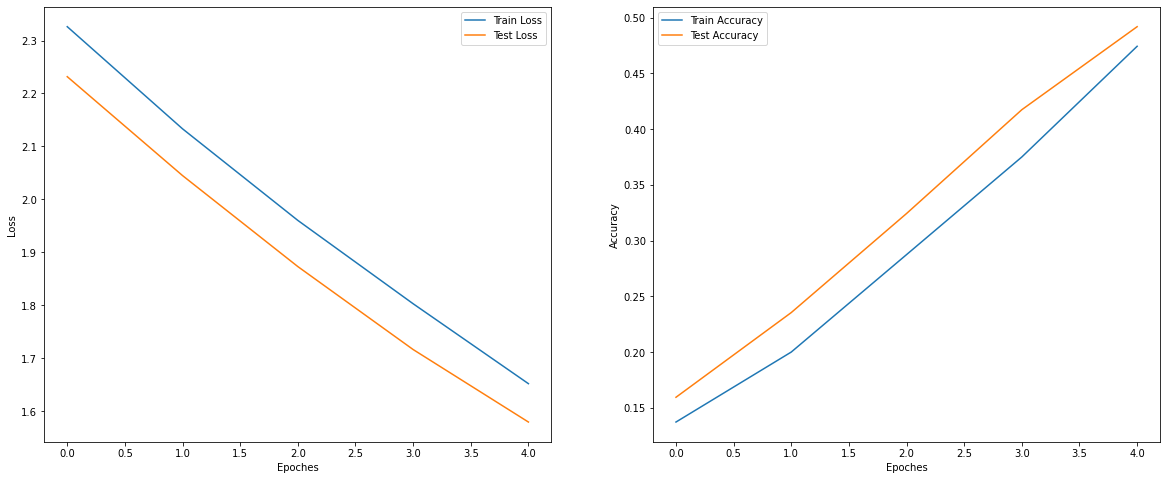

In [ ]:
# Hyperparameters
lr_rate = [0.01, 0.001] # learning rate
rho = [0.75,0.85] # coefficient used for computing a running average of squared gradients
eps = [1e-5,1e-7] # term added to the denominator to improve numerical stability
weight_decay = [0.001,0.0001] # weight decay (L2 penalty)

hyper_params = [(lr,r,e,wd) for lr in lr_rate for r in rho for e in eps for wd in weight_decay]
# print(parms_combs)

cur_iter,total_iter = 1, len(lr_rate)*len(rho)*len(eps)*len(weight_decay)

# init. epochs
epoches = 5

for h_p in hyper_params:
  print()
  print(f"current exp | total: {cur_iter} | {total_iter}")
  print(f"Training with --- lr rate: {h_p[0]}, rho: {h_p[1]}, eps: {h_p[2]}, weight decay: {h_p[3]}")
  model_18 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1).to(device)
  feature_number = model_18.fc.in_features
  model_18.fc = nn.Linear(feature_number, len(class_names)).to(device)

  optimizer = torch.optim.Adadelta(model_18.parameters(), h_p[0], h_p[1], h_p[2], h_p[3])
  model18_train_loss, model18_test_loss = [], []
  model18_train_accs, model18_test_accs = [], []

  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  for epoch in tqdm(range(epoches)):

    train_loss, train_acc = train_loop(model = model_18, dataloader = train_dataloader,
                                      loss_fn = loss_fn, optimizer = optimizer,
                                      accuracy_fn = accuracy_fn, device = device)
    
    test_loss, test_acc = test_loop(model = model_18, dataloader = test_dataloader,
                                    loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                    device = device)
    
    model18_train_loss.append(train_loss.item())
    model18_test_loss.append(test_loss.item())
    model18_train_accs.append(train_acc.item())
    model18_test_accs.append(test_acc.item())

    print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
  cur_iter += 1
  plot_graph(model18_train_loss, model18_test_loss, model18_train_accs, model18_test_accs)
  